In [1]:
!pip install scanpy
!pip install --quiet scvi-colab
from scvi_colab import install
install()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [7]:
# Block Benchmark-1: Import Libraries and Set Global Parameters

import os
import pandas as pd
import numpy as np
import scanpy as sc
import mudata as md # For loading totalVI's MuData object
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.stats import pearsonr, spearmanr
# For Leiden clustering stability test, if re-running or adapting
# from sklearn.neighbors import NearestNeighbors # Might not be needed if using Scanpy's neighbors

# --- Global Parameters and Settings ---
# Seed for reproducibility in any random operations (e.g., subsampling for stability)
RANDOM_SEED = 208
np.random.seed(RANDOM_SEED)

# Plotting settings
plt.rcParams['figure.figsize'] = (7, 7) # Default figure size
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)}) # Seaborn style
# sc.set_figure_params(dpi=100, frameon=False, facecolor='white') # Scanpy specific, can be set before sc.pl calls

print("Libraries imported and global parameters set.")
print(f"Scanpy version: {sc.__version__}")
print(f"MuData version: {md.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")



Libraries imported and global parameters set.
Scanpy version: 1.11.1
MuData version: 0.3.1
Pandas version: 2.2.2
Numpy version: 2.0.2


In [3]:
# Block Benchmark-2: Define File Paths

from google.colab import drive # Ensure drive is imported if running fresh

# --- Mount Google Drive (if not already mounted in this session) ---
# It's good practice to include this in case the notebook is run in a new session.
try:
    drive.mount('/content/drive', force_remount=True) # force_remount can be True for debugging
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise # Stop if drive cannot be mounted

# --- Base Project Path ---
gdrive_base_path = '/content/drive/My Drive/CMML_ICA2/'
print(f"Google Drive Base Path: {gdrive_base_path}")

# --- Input Data Paths ---
# Preprocessed data (containing ground truth and data for PCA/Seurat)
preprocessed_data_main_dir = os.path.join(gdrive_base_path, 'Data_Preprocessing_Outputs/data_pbmc10k_mtx/processed/')
ground_truth_metadata_path = os.path.join(preprocessed_data_main_dir, 'pbmc10k_for_SeuratPCA_preprocessed/cell_metadata_filtered.csv')

# totalVI outputs
totalvi_model_output_dir = os.path.join(gdrive_base_path, 'Model_Outputs/totalVI_pbmc_model/')
totalvi_mdata_path = os.path.join(totalvi_model_output_dir, 'pbmc10k_mdata_totalVI_benchmark_ready.h5mu')
totalvi_leiden_labels_path = os.path.join(totalvi_model_output_dir, 'totalVI_leiden_labels.csv')
totalvi_denoised_rna_path = os.path.join(totalvi_model_output_dir, 'totalVI_denoised_rna_hvg_from_layer.csv')
totalvi_denoised_protein_path = os.path.join(totalvi_model_output_dir, 'totalVI_denoised_protein_from_layer.csv')

# Seurat outputs (from R script)
seurat_model_output_dir = os.path.join(gdrive_base_path, 'Model_Outputs/Seurat_pbmc_model/')
seurat_umap_coords_path = os.path.join(seurat_model_output_dir, 'seurat_wnn_umap_coordinates.csv')
seurat_leiden_labels_path = os.path.join(seurat_model_output_dir, 'seurat_wnn_leiden_labels.csv')
seurat_processed_rna_path = os.path.join(seurat_model_output_dir, 'seurat_processed_rna_hvg_sct_data.csv')
seurat_processed_protein_path = os.path.join(seurat_model_output_dir, 'seurat_processed_adt_clr_data.csv')
# The Seurat metadata might be redundant if ground_truth_metadata_path has all GT and QC
# seurat_metadata_path = os.path.join(seurat_model_output_dir, 'seurat_cell_metadata_for_benchmark.csv')


# PCA outputs
pca_model_output_dir = os.path.join(gdrive_base_path, 'Model_Outputs/pca_pbmc_model/')
pca_h5ad_results_path = os.path.join(pca_model_output_dir, 'pbmc10k_pca_results.h5ad') # AnnData with PCA, UMAP, Leiden
pca_latent_space_path = os.path.join(pca_model_output_dir, 'pca_latent_space.csv')
pca_leiden_labels_path = os.path.join(pca_model_output_dir, 'pca_leiden_labels.csv')
pca_scaled_rna_path = os.path.join(pca_model_output_dir, 'pca_scaled_rna_hvg.csv')
pca_scaled_protein_path = os.path.join(pca_model_output_dir, 'pca_scaled_protein.csv')


# --- Output Directory for Benchmark Analysis ---
benchmark_output_dir = os.path.join(gdrive_base_path, 'Benchmark_Analysis/')
benchmark_figure_dir = os.path.join(benchmark_output_dir, 'figures/')
benchmark_data_dir = os.path.join(benchmark_output_dir, 'data/') # For summary tables etc.

os.makedirs(benchmark_output_dir, exist_ok=True)
os.makedirs(benchmark_figure_dir, exist_ok=True)
os.makedirs(benchmark_data_dir, exist_ok=True)

print(f"\nBenchmark analysis outputs will be saved to: {benchmark_output_dir}")
print("All paths defined.")
print("\nBlock Benchmark-2 finished: Path Definitions.")

Mounted at /content/drive
Google Drive mounted successfully.
Google Drive Base Path: /content/drive/My Drive/CMML_ICA2/

Benchmark analysis outputs will be saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/
All paths defined.

Block Benchmark-2 finished: Path Definitions.


In [4]:
# Block Benchmark-3: Load Ground Truth and Core Results from Each Method

print("\n--- Loading Ground Truth Metadata ---")
if not os.path.exists(ground_truth_metadata_path):
    raise FileNotFoundError(f"Ground truth metadata file not found: {ground_truth_metadata_path}")
gt_metadata_df = pd.read_csv(ground_truth_metadata_path, index_col=0) # Assuming first column is cell barcode index
print(f"Loaded ground truth metadata: {gt_metadata_df.shape[0]} cells x {gt_metadata_df.shape[1]} columns")
print("Ground truth metadata head:")
print(gt_metadata_df.head())
if "ground_truth_cell_type" not in gt_metadata_df.columns:
    raise ValueError("'ground_truth_cell_type' column not found in the loaded metadata CSV.")


# --- Load totalVI Results ---
print("\n--- Loading totalVI Results ---")
# Main data for totalVI (latent space, UMAP, Leiden labels, GT labels are already in its obs)
if not os.path.exists(totalvi_mdata_path):
    raise FileNotFoundError(f"totalVI MuData file not found: {totalvi_mdata_path}")
mdata_totalVI = md.read_h5mu(totalvi_mdata_path)
print(f"Loaded totalVI MuData object: {mdata_totalVI.n_obs} cells")
# Extract necessary components for benchmark dataframe
# Ensure alignment with gt_metadata_df's index (cell barcodes)
totalvi_latent_space = pd.DataFrame(mdata_totalVI.mod["rna_subset"].obsm["X_totalVI"], index=mdata_totalVI.mod["rna_subset"].obs_names)
totalvi_umap_coords = pd.DataFrame(mdata_totalVI.mod["rna_subset"].obsm["X_umap"], index=mdata_totalVI.mod["rna_subset"].obs_names, columns=["UMAP1", "UMAP2"])
totalvi_leiden_labels = mdata_totalVI.mod["rna_subset"].obs["leiden_totalVI"].copy() # This is a Series

# Denoised expressions for correlation
totalvi_denoised_rna_df = pd.read_csv(totalvi_denoised_rna_path, index_col=0)
totalvi_denoised_protein_df = pd.read_csv(totalvi_denoised_protein_path, index_col=0)
print("totalVI results loaded/extracted.")


# --- Load Seurat WNN Results ---
print("\n--- Loading Seurat WNN Results ---")
seurat_umap_df = pd.read_csv(seurat_umap_coords_path, index_col="cell_barcode") # cell_barcode as index
seurat_leiden_df = pd.read_csv(seurat_leiden_labels_path, index_col="cell_barcode")
seurat_rna_df = pd.read_csv(seurat_processed_rna_path, index_col=0).T # Transpose to cells x genes
seurat_protein_df = pd.read_csv(seurat_processed_protein_path, index_col=0).T # Transpose to cells x proteins
print("Seurat WNN results loaded.")


# --- Load PCA Results ---
print("\n--- Loading PCA Results ---")
# PCA results are in an H5AD, latent space also saved as CSV
pca_adata_results = sc.read_h5ad(pca_h5ad_results_path)
print(f"Loaded PCA AnnData object: {pca_adata_results.n_obs} cells")
# Extract components for benchmark dataframe
pca_latent_space = pd.DataFrame(pca_adata_results.obsm["X_pca"], index=pca_adata_results.obs_names)
pca_umap_coords = pd.DataFrame(pca_adata_results.obsm["X_umap"], index=pca_adata_results.obs_names, columns=["UMAP1", "UMAP2"])
pca_leiden_labels = pca_adata_results.obs["leiden_pca"].copy() # This is a Series

# Scaled expressions for correlation (these were scaled before PCA concatenation)
pca_rna_df = pd.read_csv(pca_scaled_rna_path, index_col=0)
pca_protein_df = pd.read_csv(pca_scaled_protein_path, index_col=0)
print("PCA results loaded/extracted.")


# --- Create a master DataFrame for Benchmark Metrics (optional but helpful) ---
# This step ensures all data is aligned by cell barcode from the ground truth metadata
# and makes it easier to access labels and latent spaces for metrics.

print("\n--- Aligning data and creating a master benchmark DataFrame ---")
# Start with ground truth metadata as the base
benchmark_df = gt_metadata_df.copy()

# Add totalVI Leiden labels and ensure alignment
benchmark_df = benchmark_df.merge(totalvi_leiden_labels.rename('leiden_totalVI'),
                                  left_index=True, right_index=True, how='left')

# Add Seurat Leiden labels
benchmark_df = benchmark_df.merge(seurat_leiden_df['leiden_wnn_seurat'].rename('leiden_seurat'), # Use specific column name
                                  left_index=True, right_index=True, how='left')

# Add PCA Leiden labels
benchmark_df = benchmark_df.merge(pca_leiden_labels.rename('leiden_pca'),
                                  left_index=True, right_index=True, how='left')

# Check for any NaNs introduced by merging (e.g., if a cell is in GT but not in a method's output)
print("\nBenchmark DataFrame head after merging labels:")
print(benchmark_df.head())
print(f"Shape of benchmark_df: {benchmark_df.shape}")
print("NaN counts per column in benchmark_df:")
print(benchmark_df.isnull().sum())

# Filter out cells that might have missing labels from any method, or handle NaNs in metric calculations
# For now, we keep all cells that are in gt_metadata_df
# Cells not present in a method's output will have NaN for that method's labels.

# Store latent spaces in a dictionary for easy access, aligned to benchmark_df's index
aligned_latent_spaces = {
    "totalVI": totalvi_latent_space.loc[benchmark_df.index],
    "PCA": pca_latent_space.loc[benchmark_df.index]
    # For Seurat, wnn_umap_coords is 2D. If you need higher-dim for cASW, you'd need to export
    # the PCA/APCA embeddings used by WNN from R, or use the UMAP coords carefully.
    # For now, let's add Seurat UMAP as its "latent representation" for cASW on UMAP space.
    # Ensure seurat_umap_df is indexed by cell barcodes that match benchmark_df.index
}
# Align Seurat UMAP coordinates
seurat_umap_aligned = seurat_umap_df.loc[benchmark_df.index.intersection(seurat_umap_df.index)]
aligned_latent_spaces["Seurat_UMAP"] = seurat_umap_aligned # Store the 2D UMAP for Seurat

# Store UMAP coordinates similarly for consistent plotting access
aligned_umap_coords = {
    "totalVI": totalvi_umap_coords.loc[benchmark_df.index],
    "PCA": pca_umap_coords.loc[benchmark_df.index],
    "Seurat": seurat_umap_aligned # Already aligned
}


print("\nBlock Benchmark-3 finished: Data Loading for all methods.")


--- Loading Ground Truth Metadata ---
Loaded ground truth metadata: 7611 cells x 7 columns
Ground truth metadata head:
                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACATCGGTTA-1               2093        6713.0            415.0   
AAACCCAGTACCGCGT-1               1518        3637.0            287.0   
AAACCCAGTATCGAAA-1                737        1244.0            110.0   
AAACCCAGTCGTCATA-1               1240        2611.0            156.0   
AAACCCAGTCTACACA-1               2022        5035.0            477.0   

                    pct_counts_mt  n_protein_counts  n_proteins  \
AAACCCACATCGGTTA-1       6.182035            1475.0          17   
AAACCCAGTACCGCGT-1       7.891120            7149.0          17   
AAACCCAGTATCGAAA-1       8.842443            6831.0          17   
AAACCCAGTCGTCATA-1       5.974722            6839.0          17   
AAACCCAGTCTACACA-1       9.473684            4720.0          17   

                   ground_truth_cell_type  


/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_com

Loaded totalVI MuData object: 7611 cells
totalVI results loaded/extracted.

--- Loading Seurat WNN Results ---
Seurat WNN results loaded.

--- Loading PCA Results ---
Loaded PCA AnnData object: 7611 cells
PCA results loaded/extracted.

--- Aligning data and creating a master benchmark DataFrame ---

Benchmark DataFrame head after merging labels:
                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACATCGGTTA-1               2093        6713.0            415.0   
AAACCCAGTACCGCGT-1               1518        3637.0            287.0   
AAACCCAGTATCGAAA-1                737        1244.0            110.0   
AAACCCAGTCGTCATA-1               1240        2611.0            156.0   
AAACCCAGTCTACACA-1               2022        5035.0            477.0   

                    pct_counts_mt  n_protein_counts  n_proteins  \
AAACCCACATCGGTTA-1       6.182035            1475.0          17   
AAACCCAGTACCGCGT-1       7.891120            7149.0          17   
AAACCCAGTATCGAAA-1

In [ ]:
# Block Benchmark-4a: Load Expression Data for Visualization

print("\n--- Loading Processed/Denoised RNA Expression Data for Marker Gene Visualization ---")

# Ensure cell barcodes are consistent as index across these DataFrames
# And that genes are columns (or transpose if they are rows)

# totalVI
if os.path.exists(totalvi_denoised_rna_path):
    rna_totalVI_viz = pd.read_csv(totalvi_denoised_rna_path, index_col=0) # Assuming cells are rows, genes are columns
    # Ensure index matches benchmark_df (it should if generated from same cells)
    rna_totalVI_viz = rna_totalVI_viz.reindex(benchmark_df.index)
    print(f"Loaded totalVI denoised RNA for viz: {rna_totalVI_viz.shape}")
else:
    print(f"ERROR: totalVI denoised RNA file not found at {totalvi_denoised_rna_path}")
    rna_totalVI_viz = pd.DataFrame(index=benchmark_df.index) # Empty df to avoid later errors

# Seurat
if os.path.exists(seurat_processed_rna_path):
    # Seurat CSV was saved as genes x cells, so needs transpose. Also, index was gene names.
    rna_seurat_viz_raw = pd.read_csv(seurat_processed_rna_path, index_col=0)
    rna_seurat_viz = rna_seurat_viz_raw.T # Transpose to cells x genes
    rna_seurat_viz = rna_seurat_viz.reindex(benchmark_df.index) # Align cells
    print(f"Loaded Seurat processed RNA for viz: {rna_seurat_viz.shape}")
else:
    print(f"ERROR: Seurat processed RNA file not found at {seurat_processed_rna_path}")
    rna_seurat_viz = pd.DataFrame(index=benchmark_df.index)

# PCA
# pca_scaled_rna_path contains scaled RNA HVGs (cells x genes)
if os.path.exists(pca_scaled_rna_path):
    rna_pca_viz = pd.read_csv(pca_scaled_rna_path, index_col=0) # Already cells x genes
    rna_pca_viz = rna_pca_viz.reindex(benchmark_df.index)
    print(f"Loaded PCA scaled RNA for viz: {rna_pca_viz.shape}")
else:
    print(f"ERROR: PCA scaled RNA file not found at {pca_scaled_rna_path}")
    rna_pca_viz = pd.DataFrame(index=benchmark_df.index)

# Store these in a dictionary for easier access in the plotting loop
expression_data_for_viz = {
    "totalVI": rna_totalVI_viz,
    "Seurat": rna_seurat_viz,
    "PCA": rna_pca_viz
}

# Define the marker genes
marker_genes_to_plot = ["IL7R", "LYZ", "CD8A", "NKG7"]

# Check if marker genes are present in the datasets
for method, df in expression_data_for_viz.items():
    if not df.empty:
        missing_markers = [gene for gene in marker_genes_to_plot if gene not in df.columns]
        if missing_markers:
            print(f"Warning: For method '{method}', the following marker genes are missing from its expression data: {missing_markers}")
    else:
        print(f"Warning: Expression data for method '{method}' is empty.")


print("\nBlock Benchmark-4a finished: Loading Expression Data for Visualization.")


--- Loading Processed/Denoised RNA Expression Data for Marker Gene Visualization ---
Loaded totalVI denoised RNA for viz: (7611, 4000)
Loaded Seurat processed RNA for viz: (7611, 3000)
Loaded PCA scaled RNA for viz: (7611, 4000)

Block Benchmark-4a finished: Loading Expression Data for Visualization.


In [ ]:
mdata_totalVI

MuData object with n_obs × n_vars = 7611 × 21951
  obs:	'_scvi_labels'
  uns:	'_scvi_manager_uuid', '_scvi_uuid'
  obsm:	'X_totalVI'
  3 modalities
    rna:	7611 x 17934
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'
    protein:	7611 x 17
      obs:	'_scvi_batch'
      var:	'clean_names'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	7611 x 4000
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type', '_scvi_batch', 'leiden_totalVI'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'leiden_totalVI', 'log1p', 'protein_names', 'rna_subset:ground_truth_cell_type_colors', 'rna_subset:leiden_totalVI_colors', 'totalVI_neighbors_rna', 'umap'
      obsm:	'X_totalVI', 'X_umap'
      layers:	'counts', 'denoised_rna'
      obsp:	'totalVI_neighbors_rna_connectivities', 'totalVI_neighbors_rna_distances'


--- Generating Beautified 3x6 and Simplified 3x3 UMAP Visualization Grids ---

Generating Full 3x6 UMAP Grid...


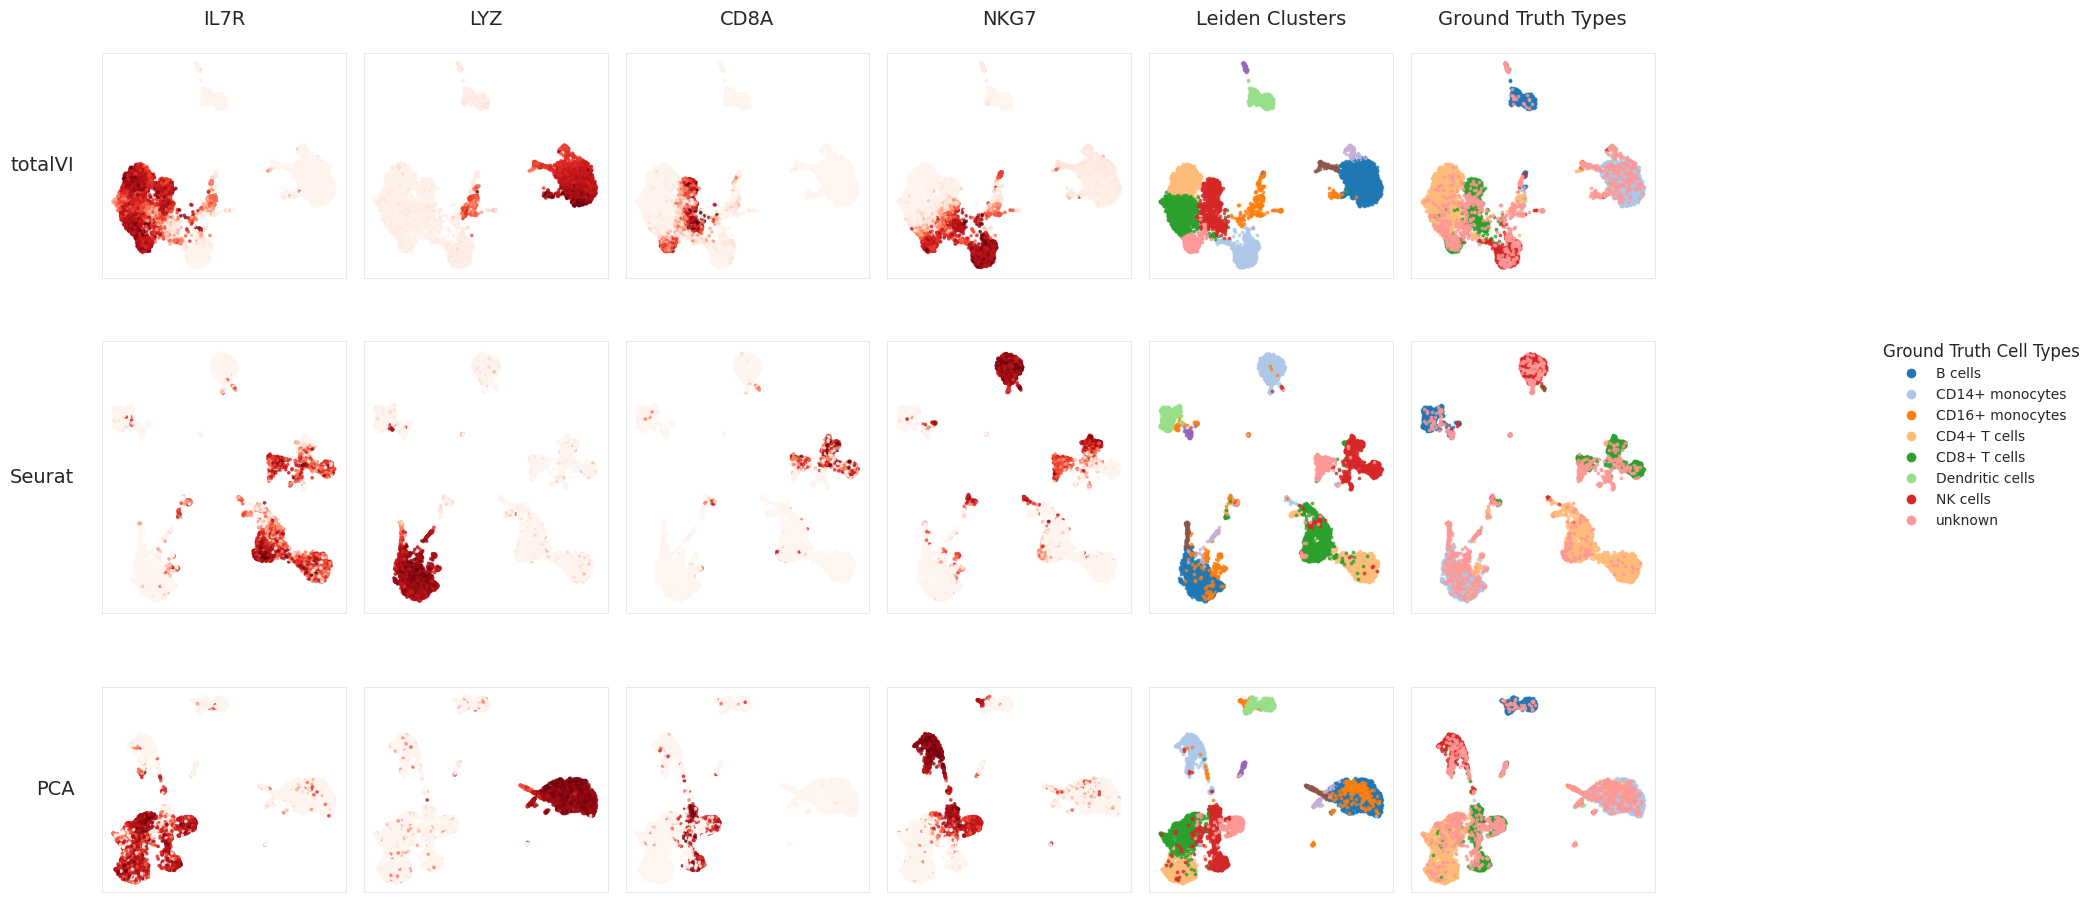

Beautified 3x6 UMAP visualization grid saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_umap_grid_3x6_beautified.png

Generating Simplified 3x3 UMAP Grid...


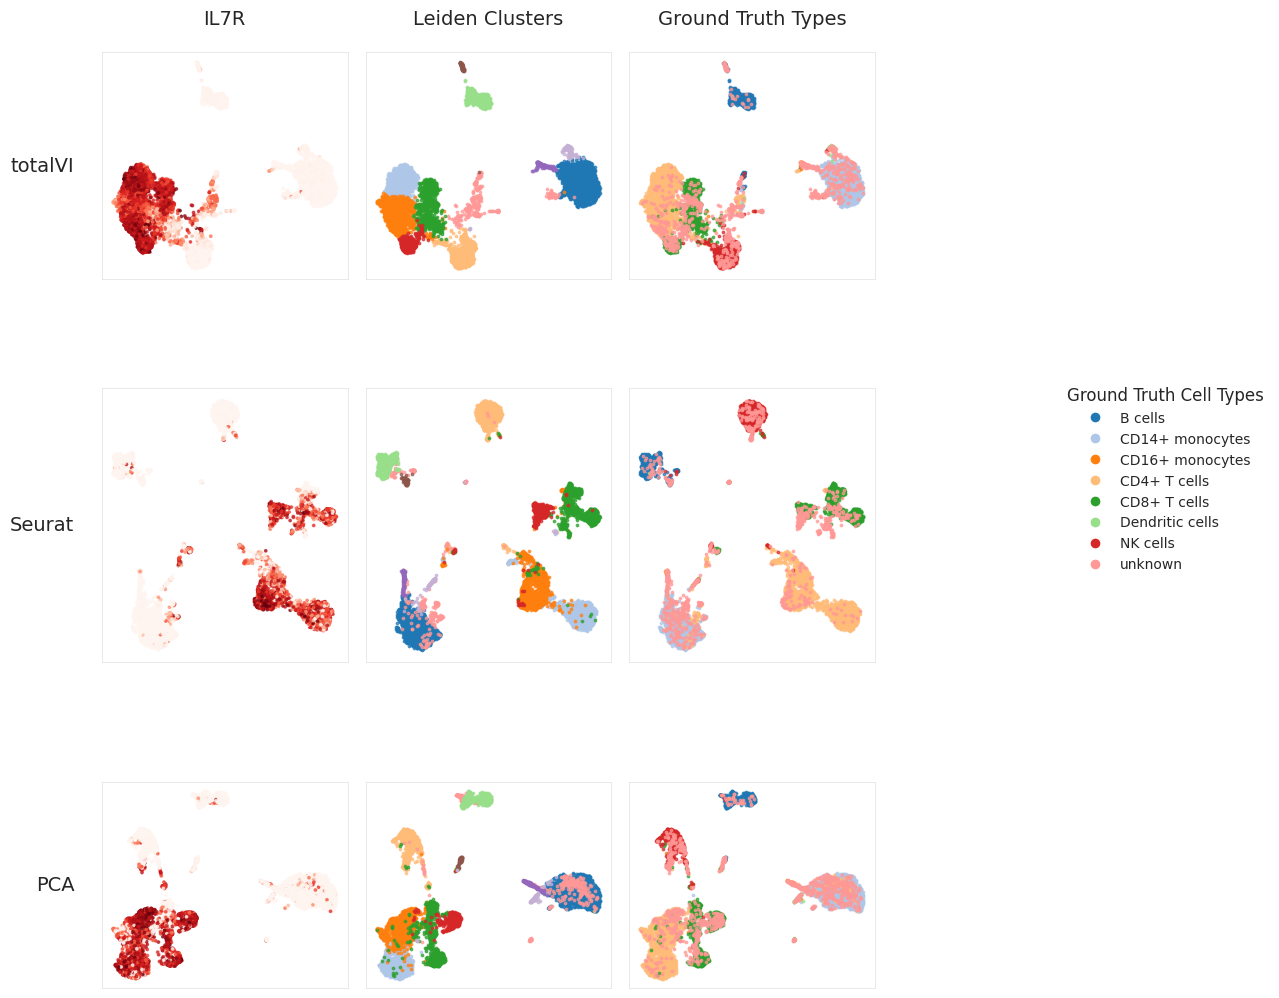

Simplified 3x3 UMAP visualization grid saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_umap_grid_3x3_simplified.png

Block Benchmark-4b finished: Beautified UMAP Grids generation.


In [ ]:
# Block Benchmark-4b: Create the 3x6 UMAP Visualization Grid (Beautified + Simplified Version)

print("\n--- Generating Beautified 3x6 and Simplified 3x3 UMAP Visualization Grids ---")

methods_to_plot = ["totalVI", "Seurat", "PCA"]
marker_genes_to_plot = ["IL7R", "LYZ", "CD8A", "NKG7"]
# For the 3x6 plot
plot_columns_titles_full = marker_genes_to_plot + ["Leiden Clusters", "Ground Truth Types"]
n_rows_viz = len(methods_to_plot)
n_cols_viz_full = len(plot_columns_titles_full)

# For the 3x3 simplified plot
plot_columns_titles_simple = ["IL7R", "Leiden Clusters", "Ground Truth Types"]
n_cols_viz_simple = len(plot_columns_titles_simple)


# --- Create a consistent color map for Ground Truth labels (used in both plots) ---
gt_labels_series = benchmark_df["ground_truth_cell_type"]
unique_gt_labels = sorted(gt_labels_series.astype('category').cat.categories.tolist()) # Sort for consistent legend order
# Use a perceptually uniform and distinct colormap from matplotlib or seaborn
# For example, 'tab20' is good for up to 20 categories. If more, consider 'tab20b', 'tab20c' or a custom map.
# Or use scanpy's default, which is quite good.
if len(unique_gt_labels) <= 20:
    gt_palette = sns.color_palette("tab20", n_colors=len(unique_gt_labels))
elif len(unique_gt_labels) <= 40: # tab20 + tab20b
    gt_palette = sns.color_palette("tab20", n_colors=20) + sns.color_palette("tab20b", n_colors=len(unique_gt_labels)-20)
else: # default_102 from scanpy is good for many categories
    gt_palette = sc.pl.palettes.default_102[:len(unique_gt_labels)]

gt_color_map = {label: gt_palette[i] for i, label in enumerate(unique_gt_labels)}


# --- 1. Generate the Full 3x6 UMAP Grid ---
print("\nGenerating Full 3x6 UMAP Grid...")
fig_full, axes_full = plt.subplots(n_rows_viz, n_cols_viz_full,
                                   figsize=(n_cols_viz_full * 3.5, n_rows_viz * 3.5), # Adjust fig size for compactness
                                   squeeze=False) # Ensure axes_full is always 2D array
plt.subplots_adjust(wspace=0.1, hspace=0.1) # Reduce spacing

for i, method_name in enumerate(methods_to_plot):
    # Get UMAP coordinates (assuming aligned_umap_coords is correctly populated and aligned)
    umap_coords = aligned_umap_coords[method_name].values

    # Get Leiden labels
    method_leiden_labels = benchmark_df[f"leiden_totalVI"]

    # Get expression data
    method_expr_df = expression_data_for_viz.get(method_name, pd.DataFrame())

    for j, plot_type_title_full in enumerate(plot_columns_titles_full):
        ax = axes_full[i, j]

        if plot_type_title_full in marker_genes_to_plot:
            if not method_expr_df.empty and plot_type_title_full in method_expr_df.columns:
                gene_expression = method_expr_df[plot_type_title_full]
                # Custom colormap: white to light red/pink
                # cmap_gene = sns.light_palette("red", as_cmap=True) # Simple light red
                cmap_gene = sns.color_palette("Reds", as_cmap=True) # More standard "Reds"

                # Normalize expression for better color mapping if needed (e.g., clip outliers)
                vmin_expr = np.percentile(gene_expression.dropna(), 1)
                vmax_expr = np.percentile(gene_expression.dropna(), 99)

                ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=3, c=gene_expression,
                           cmap=cmap_gene, alpha=0.7, vmin=vmin_expr, vmax=vmax_expr, rasterized=True) # rasterized for large N
                # No colorbar for individual gene plots as requested
            else:
                ax.text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=10)
            # No title for individual subplots as requested
            # ax.set_title(f"{method_name}: {plot_type_title_full} Expr.", fontsize=10) # Original title

        elif plot_type_title_full == "Leiden Clusters":
            leiden_codes, leiden_cats = pd.factorize(method_leiden_labels)
            num_leiden_clusters = len(leiden_cats)
            # Use a distinct, qualitative colormap
            if num_leiden_clusters <= 20:
                leiden_palette_viz = sns.color_palette("tab20", n_colors=num_leiden_clusters)
            else: # Fallback for more clusters
                leiden_palette_viz = sns.color_palette(sc.pl.palettes.default_102, n_colors=num_leiden_clusters)

            for k_idx, cluster_label in enumerate(leiden_cats):
                cluster_mask = (method_leiden_labels == cluster_label)
                if np.sum(cluster_mask) > 0: # Only plot if cells exist in cluster
                    ax.scatter(umap_coords[cluster_mask, 0], umap_coords[cluster_mask, 1],
                               s=3, color=leiden_palette_viz[k_idx], label=str(cluster_label), alpha=0.7, rasterized=True)
            # No title, no individual legend
            # ax.set_title(f"{method_name}: Leiden", fontsize=10)

        elif plot_type_title_full == "Ground Truth Types":
            current_gt_labels_for_plot = benchmark_df.loc[aligned_umap_coords[method_name].index, "ground_truth_cell_type"]
            for gt_label_cat in unique_gt_labels: # Iterate in sorted order for consistent legend
                gt_mask = (current_gt_labels_for_plot == gt_label_cat)
                if np.sum(gt_mask) > 0:
                    ax.scatter(umap_coords[gt_mask, 0], umap_coords[gt_mask, 1],
                               s=3, color=gt_color_map[gt_label_cat], label=str(gt_label_cat), alpha=0.7, rasterized=True)
            # No title, legend will be added globally
            # ax.set_title(f"{method_name}: Ground Truth", fontsize=10)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([]) # Also remove tick labels explicitly
        ax.set_yticklabels([])
        ax.set_xlabel("")     # Remove x-axis label
        ax.set_ylabel("")     # Remove y-axis label

        # --- MODIFIED: Add very light grey spines for subtle separation ---
        very_light_grey = "#e0e0e0" # A light grey color
        spine_linewidth = 0.5     # Thin lines

        ax.spines['right'].set_visible(True) # Make them visible
        ax.spines['top'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

        ax.spines['right'].set_color(very_light_grey)
        ax.spines['top'].set_color(very_light_grey)
        ax.spines['left'].set_color(very_light_grey)
        ax.spines['bottom'].set_color(very_light_grey)

        ax.spines['right'].set_linewidth(spine_linewidth)
        ax.spines['top'].set_linewidth(spine_linewidth)
        ax.spines['left'].set_linewidth(spine_linewidth)
        ax.spines['bottom'].set_linewidth(spine_linewidth)
        # --- END MODIFICATION ---

        ax.grid(False) # Keep grid off
        ax.set_facecolor('white') # Ensure background is white
        ax.set_aspect('equal', adjustable='box')

# Add row labels (Method names) to the left of the grid
for i, method_name in enumerate(methods_to_plot):
    axes_full[i, 0].set_ylabel(method_name, fontsize=14, labelpad=20, rotation=0, ha='right', va='center')

# Add column labels (Plot types) to the top of the grid
for j, plot_type_title_full in enumerate(plot_columns_titles_full):
    axes_full[0, j].set_title(plot_type_title_full, fontsize=14, pad=20)


# Add a single global legend for Ground Truth types to the right of the entire plot
# We need to create dummy scatter points for the legend items
legend_handles_gt = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                markersize=8, markerfacecolor=gt_color_map[label])
                     for label in unique_gt_labels]
fig_full.legend(handles=legend_handles_gt, title="Ground Truth Cell Types",
                loc='center right', bbox_to_anchor=(1.05, 0.5), # Adjust bbox_to_anchor as needed
                fontsize=10, title_fontsize=12, frameon=False)

# Adjust layout to prevent overlap and make space for global legend
fig_full.tight_layout(rect=[0.05, 0, 0.85, 0.95]) # Adjust rect: [left, bottom, right, top]

benchmark_viz_grid_full_path = os.path.join(benchmark_figure_dir, "benchmark_umap_grid_3x6_beautified.png")
plt.savefig(benchmark_viz_grid_full_path, dpi=300) # bbox_inches='tight' might conflict with fig.legend outside axes
plt.show()
plt.close(fig_full)
print(f"Beautified 3x6 UMAP visualization grid saved to: {benchmark_viz_grid_full_path}")


# --- 2. Generate the Simplified 3x3 UMAP Grid (IL7R, Leiden, Ground Truth) ---
print("\nGenerating Simplified 3x3 UMAP Grid...")
fig_simple, axes_simple = plt.subplots(n_rows_viz, n_cols_viz_simple,
                                       figsize=(n_cols_viz_simple * 4, n_rows_viz * 4), # Adjust size
                                       squeeze=False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, method_name in enumerate(methods_to_plot):
    umap_coords = aligned_umap_coords[method_name].values
    method_leiden_labels = benchmark_df[f"leiden_totalVI"]
    method_expr_df = expression_data_for_viz.get(method_name, pd.DataFrame())

    for j, plot_type_title_simple in enumerate(plot_columns_titles_simple):
        ax = axes_simple[i, j]

        if plot_type_title_simple == "IL7R": # Marker gene
            if not method_expr_df.empty and "IL7R" in method_expr_df.columns:
                gene_expression = method_expr_df["IL7R"]
                cmap_gene = sns.color_palette("Reds", as_cmap=True)
                vmin_expr = np.percentile(gene_expression.dropna(), 1)
                vmax_expr = np.percentile(gene_expression.dropna(), 99)
                ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=3, c=gene_expression,
                           cmap=cmap_gene, alpha=0.7, vmin=vmin_expr, vmax=vmax_expr, rasterized=True)
            else:
                ax.text(0.5, 0.5, "IL7R\nN/A", ha='center', va='center', fontsize=10)

        elif plot_type_title_simple == "Leiden Clusters":
            leiden_codes, leiden_cats = pd.factorize(method_leiden_labels)
            num_leiden_clusters = len(leiden_cats)
            if num_leiden_clusters <= 20:
                leiden_palette_viz = sns.color_palette("tab20", n_colors=num_leiden_clusters)
            else:
                leiden_palette_viz = sns.color_palette(sc.pl.palettes.default_102, n_colors=num_leiden_clusters)

            actual_unique_leiden_labels = method_leiden_labels.unique() # Get actual unique labels in order
            leiden_color_map_simple_viz = {label: leiden_palette_viz[k_idx] for k_idx, label in enumerate(pd.Series(actual_unique_leiden_labels).astype('category').cat.categories)}


            for cluster_label_val in actual_unique_leiden_labels:
                cluster_mask = (method_leiden_labels == cluster_label_val)
                if np.sum(cluster_mask) > 0:
                    ax.scatter(umap_coords[cluster_mask, 0], umap_coords[cluster_mask, 1],
                               s=3, color=leiden_color_map_simple_viz.get(cluster_label_val, "grey"), # Use .get for safety
                               label=str(cluster_label_val), alpha=0.7, rasterized=True)

        elif plot_type_title_simple == "Ground Truth Types":
            current_gt_labels_for_plot = benchmark_df.loc[aligned_umap_coords[method_name].index, "ground_truth_cell_type"]
            for gt_label_cat in unique_gt_labels:
                gt_mask = (current_gt_labels_for_plot == gt_label_cat)
                if np.sum(gt_mask) > 0:
                    ax.scatter(umap_coords[gt_mask, 0], umap_coords[gt_mask, 1],
                               s=3, color=gt_color_map[gt_label_cat], label=str(gt_label_cat), alpha=0.7, rasterized=True)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")

        # --- MODIFIED: Add very light grey spines for subtle separation ---
        very_light_grey = "#e0e0e0"
        spine_linewidth = 0.5

        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

        ax.spines['right'].set_color(very_light_grey)
        ax.spines['top'].set_color(very_light_grey)
        ax.spines['left'].set_color(very_light_grey)
        ax.spines['bottom'].set_color(very_light_grey)

        ax.spines['right'].set_linewidth(spine_linewidth)
        ax.spines['top'].set_linewidth(spine_linewidth)
        ax.spines['left'].set_linewidth(spine_linewidth)
        ax.spines['bottom'].set_linewidth(spine_linewidth)
        # --- END MODIFICATION ---

        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_aspect('equal', adjustable='box')

# Add row labels (Method names) to the left of the simplified grid
for i, method_name in enumerate(methods_to_plot):
    axes_simple[i, 0].set_ylabel(method_name, fontsize=14, labelpad=20, rotation=0, ha='right', va='center')

# Add column labels (Plot types) to the top of the simplified grid
for j, plot_type_title_simple in enumerate(plot_columns_titles_simple):
    axes_simple[0, j].set_title(plot_type_title_simple, fontsize=14, pad=20)

# Add a single global legend for Ground Truth types to the right of the simplified plot
fig_simple.legend(handles=legend_handles_gt, title="Ground Truth Cell Types", # Re-use legend_handles_gt
                  loc='center right', bbox_to_anchor=(1.12, 0.5), # Adjust bbox for new fig size
                  fontsize=10, title_fontsize=12, frameon=False)

fig_simple.tight_layout(rect=[0.05, 0, 0.8, 0.95]) # Adjust rect for legend

benchmark_viz_grid_simple_path = os.path.join(benchmark_figure_dir, "benchmark_umap_grid_3x3_simplified.png")
plt.savefig(benchmark_viz_grid_simple_path, dpi=300)
plt.show()
plt.close(fig_simple)
print(f"Simplified 3x3 UMAP visualization grid saved to: {benchmark_viz_grid_simple_path}")

print("\nBlock Benchmark-4b finished: Beautified UMAP Grids generation.")

In [ ]:
print("\n--- Benchmark Metric 1: Clustering vs GT (ARI, NMI) & Cell Type Silhouette on UMAP (cASW_UMAP) ---")

metrics_results = {"method": [], "ARI": [], "NMI": [], "cASW_on_UMAP": []}

for method_name in methods_to_plot:
    print(f"\nCalculating metrics for method: {method_name}")
    metrics_results["method"].append(method_name)

    # --- Get Leiden labels (same as before) ---
    leiden_col_for_method = None
    if method_name == "totalVI":
        if "leiden_totalvi" in benchmark_df.columns: leiden_col_for_method = "leiden_totalvi"
        elif "leiden_totalVI" in benchmark_df.columns: leiden_col_for_method = "leiden_totalVI"
    elif method_name == "Seurat":
        if "leiden_seurat" in benchmark_df.columns: leiden_col_for_method = "leiden_seurat"
    elif method_name == "PCA":
        if "leiden_pca" in benchmark_df.columns: leiden_col_for_method = "leiden_pca"

    if leiden_col_for_method and leiden_col_for_method in benchmark_df.columns:
        method_leiden_labels = benchmark_df[leiden_col_for_method]
        current_gt_labels = gt_labels_series.loc[method_leiden_labels.index]
        valid_indices_for_metrics = current_gt_labels.notna() & method_leiden_labels.notna()
        if valid_indices_for_metrics.sum() < 2:
            print(f"  Not enough valid samples for ARI/NMI for {method_name}.")
            ari_score, nmi_score = np.nan, np.nan
        else:
            ari_score = adjusted_rand_score(current_gt_labels[valid_indices_for_metrics], method_leiden_labels[valid_indices_for_metrics])
            nmi_score = normalized_mutual_info_score(current_gt_labels[valid_indices_for_metrics], method_leiden_labels[valid_indices_for_metrics])
        metrics_results["ARI"].append(ari_score)
        print(f"  ARI (vs Ground Truth): {ari_score:.4f}")
        metrics_results["NMI"].append(nmi_score)
        print(f"  NMI (vs Ground Truth): {nmi_score:.4f}")
    else:
        print(f"  Leiden labels for {method_name} (column: {leiden_col_for_method}) not found in benchmark_df. Appending NaN for ARI/NMI.")
        metrics_results["ARI"].append(np.nan)
        metrics_results["NMI"].append(np.nan)

    # --- Calculate cASW using the method's 2D UMAP coordinates ---
    appended_casw = False # Flag to check if cASW was appended
    if method_name in aligned_umap_coords:
        umap_coords_for_casw = aligned_umap_coords[method_name]
        common_casw_index = gt_labels_series.index.intersection(umap_coords_for_casw.index)
        gt_labels_for_casw = gt_labels_series.loc[common_casw_index].dropna()
        umap_data_for_casw_calc = umap_coords_for_casw.loc[gt_labels_for_casw.index].dropna(axis=0, how='any')
        gt_labels_for_casw = gt_labels_for_casw.loc[umap_data_for_casw_calc.index]

        print(f"  Method for cASW_on_UMAP: {method_name}")
        print(f"    Shape of umap_data_for_casw_calc after alignment: {umap_data_for_casw_calc.shape}")
        print(f"    Number of unique GT labels for cASW: {gt_labels_for_casw.nunique() if len(gt_labels_for_casw) > 0 else 0}")

        if len(gt_labels_for_casw.unique()) < 2 or \
           umap_data_for_casw_calc.shape[0] < 2 or \
           len(gt_labels_for_casw) != umap_data_for_casw_calc.shape[0] or \
           umap_data_for_casw_calc.empty or \
           umap_data_for_casw_calc.shape[1] < 2:
            print(f"    Condition for skipping cASW_on_UMAP met for {method_name}.")
            metrics_results["cASW_on_UMAP"].append(np.nan)
            appended_casw = True
        else:
            try:
                casw_umap_score = silhouette_score(umap_data_for_casw_calc.values, gt_labels_for_casw.values)
                metrics_results["cASW_on_UMAP"].append(casw_umap_score)
                appended_casw = True
                print(f"    cASW (on UMAP, vs Ground Truth): {casw_umap_score:.4f}")
            except ValueError as e_casw_umap:
                print(f"    Error calculating cASW_on_UMAP for {method_name}: {e_casw_umap}. Appending NaN.")
                metrics_results["cASW_on_UMAP"].append(np.nan)
                appended_casw = True
    else: # method_name not in aligned_umap_coords
        print(f"  UMAP coordinates for {method_name} not found in aligned_umap_coords. Appending NaN for cASW_on_UMAP.")
        metrics_results["cASW_on_UMAP"].append(np.nan)
        appended_casw = True

    if not appended_casw: # Should not happen with the logic above, but as a safeguard
        print(f"  CRITICAL WARNING: cASW_on_UMAP was NOT appended for method {method_name}!")
        metrics_results["cASW_on_UMAP"].append(np.nan) # Ensure it's always appended

    # --- DEBUG PRINT: Check lengths after each method ---
    print(f"  Lengths after {method_name}:")
    for key, value_list in metrics_results.items():
        print(f"    {key}: {len(value_list)}")


# --- Convert results to DataFrame and Save ---
metrics_df = pd.DataFrame(metrics_results)
print("\n--- Metrics Summary (ARI, NMI, cASW_on_UMAP) ---")
print(metrics_df.to_string())
metrics_csv_path_umap_casw = os.path.join(benchmark_data_dir, "benchmark_metrics_ari_nmi_casw_on_umap.csv")
metrics_df.to_csv(metrics_csv_path_umap_casw, index=False)
print(f"Metrics summary (with cASW on UMAP) saved to: {metrics_csv_path_umap_casw}")


--- Benchmark Metric 1: Clustering vs GT (ARI, NMI) & Cell Type Silhouette on UMAP (cASW_UMAP) ---

Calculating metrics for method: totalVI
  ARI (vs Ground Truth): 0.5927
  NMI (vs Ground Truth): 0.6646
  Method for cASW_on_UMAP: totalVI
    Shape of umap_data_for_casw_calc after alignment: (7611, 2)
    Number of unique GT labels for cASW: 8
    cASW (on UMAP, vs Ground Truth): 0.2898
  Lengths after totalVI:
    method: 1
    ARI: 1
    NMI: 1
    cASW_on_UMAP: 1

Calculating metrics for method: Seurat
  ARI (vs Ground Truth): 0.4772
  NMI (vs Ground Truth): 0.6139
  Method for cASW_on_UMAP: Seurat
    Shape of umap_data_for_casw_calc after alignment: (7611, 2)
    Number of unique GT labels for cASW: 8
    cASW (on UMAP, vs Ground Truth): 0.4290
  Lengths after Seurat:
    method: 2
    ARI: 2
    NMI: 2
    cASW_on_UMAP: 2

Calculating metrics for method: PCA
  ARI (vs Ground Truth): 0.5586
  NMI (vs Ground Truth): 0.6420
  Method for cASW_on_UMAP: PCA
    Shape of umap_data_for_


--- Visualizing ARI, NMI, cASW_on_UMAP Metrics (Fixed Order, Fresher Colors, Corrected Ticks) ---


<ipython-input-30-50f8e1e486a9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y="ARI", data=metrics_df,
<ipython-input-30-50f8e1e486a9>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y="NMI", data=metrics_df,
<ipython-input-30-50f8e1e486a9>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y="cASW_on_UMAP", data=metrics_df,


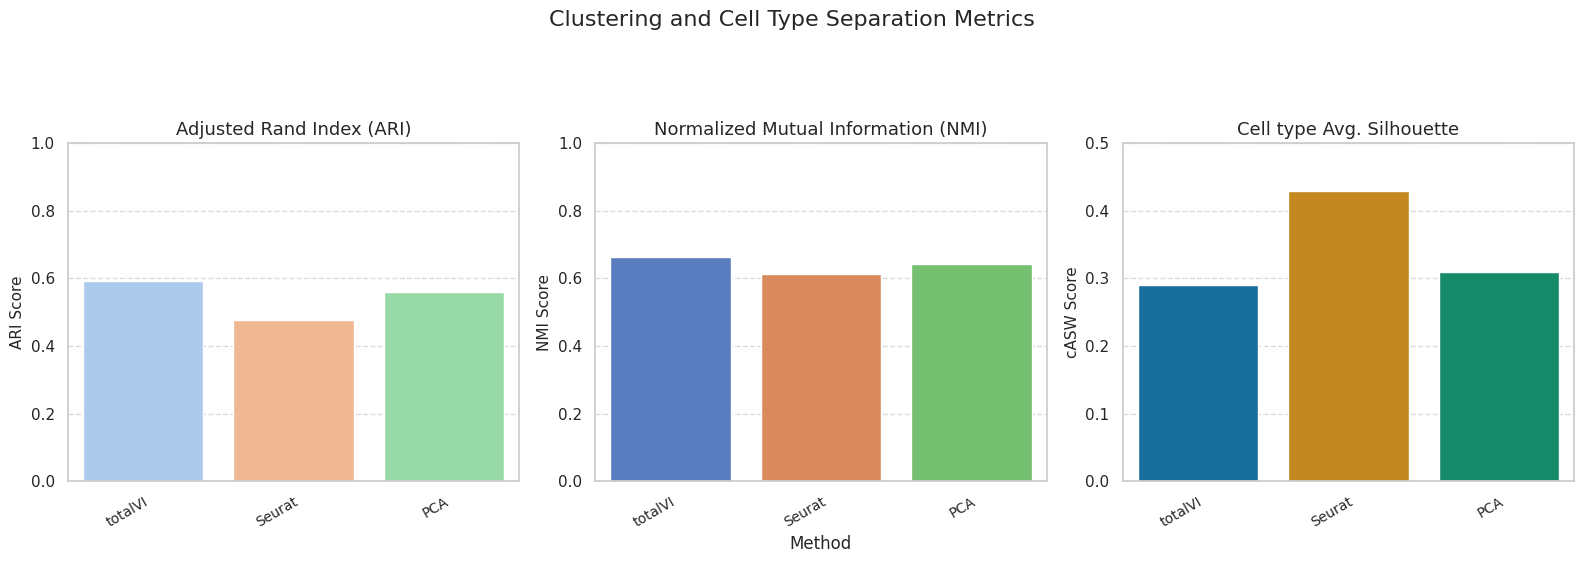

Metrics bar plot (fixed order, new colors, corrected ticks) saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_plot_ari_nmi_casw_fixed_order_v2.png

Block Benchmark-5 finished: ARI, NMI, cASW_on_UMAP calculation and visualization (fixed order, corrected ticks).


In [ ]:
print("\n--- Visualizing ARI, NMI, cASW_on_UMAP Metrics (Fixed Order, Fresher Colors, Corrected Ticks) ---")
if not metrics_df.empty:
    method_order = ["totalVI", "Seurat", "PCA"]
    palette_ari = sns.color_palette("pastel", n_colors=len(method_order))
    palette_nmi = sns.color_palette("muted", n_colors=len(method_order))
    palette_casw = sns.color_palette("colorblind", n_colors=len(method_order))

    fig_metrics_umap_casw, axs_metrics_umap_casw = plt.subplots(1, 3, figsize=(16, 5.5))
    plt.subplots_adjust(wspace=0.3)

    # --- ARI Plot ---
    sns.barplot(x="method", y="ARI", data=metrics_df,
                order=method_order,
                ax=axs_metrics_umap_casw[0],
                palette=palette_ari)
    axs_metrics_umap_casw[0].set_title("Adjusted Rand Index (ARI)", fontsize=13)
    axs_metrics_umap_casw[0].set_ylabel("ARI Score", fontsize=11)
    axs_metrics_umap_casw[0].set_xlabel("")
    # Correct way to set x-tick label properties:
    axs_metrics_umap_casw[0].tick_params(axis='x', labelsize=10, rotation=30) # Only size and rotation here
    # For horizontal alignment with rotation, apply to the labels themselves:
    plt.setp(axs_metrics_umap_casw[0].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    axs_metrics_umap_casw[0].grid(axis='y', linestyle='--', alpha=0.7)
    axs_metrics_umap_casw[0].set_ylim(0, max(1.0, metrics_df["ARI"].max() * 1.1) if metrics_df["ARI"].notna().any() else 1.0)

    # --- NMI Plot ---
    sns.barplot(x="method", y="NMI", data=metrics_df,
                order=method_order,
                ax=axs_metrics_umap_casw[1],
                palette=palette_nmi)
    axs_metrics_umap_casw[1].set_title("Normalized Mutual Information (NMI)", fontsize=13)
    axs_metrics_umap_casw[1].set_ylabel("NMI Score", fontsize=11)
    axs_metrics_umap_casw[1].set_xlabel("Method", fontsize=12)
    axs_metrics_umap_casw[1].tick_params(axis='x', labelsize=10, rotation=30)
    plt.setp(axs_metrics_umap_casw[1].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    axs_metrics_umap_casw[1].grid(axis='y', linestyle='--', alpha=0.7)
    axs_metrics_umap_casw[1].set_ylim(0, max(1.0, metrics_df["NMI"].max() * 1.1) if metrics_df["NMI"].notna().any() else 1.0)

    # --- cASW_on_UMAP Plot ---
    sns.barplot(x="method", y="cASW_on_UMAP", data=metrics_df,
                order=method_order,
                ax=axs_metrics_umap_casw[2],
                palette=palette_casw)
    axs_metrics_umap_casw[2].set_title("Cell type Avg. Silhouette", fontsize=13)
    axs_metrics_umap_casw[2].set_ylabel("cASW Score", fontsize=11)
    axs_metrics_umap_casw[2].set_xlabel("")
    axs_metrics_umap_casw[2].tick_params(axis='x', labelsize=10, rotation=30)
    plt.setp(axs_metrics_umap_casw[2].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    axs_metrics_umap_casw[2].grid(axis='y', linestyle='--', alpha=0.7)
    min_casw = metrics_df["cASW_on_UMAP"].min() if metrics_df["cASW_on_UMAP"].notna().any() else -0.1
    max_casw = metrics_df["cASW_on_UMAP"].max() if metrics_df["cASW_on_UMAP"].notna().any() else 0.5
    axs_metrics_umap_casw[2].set_ylim(min(0, min_casw * (1.1 if min_casw < 0 else 0.9) if pd.notna(min_casw) else -0.1),
                                     max(0.5, max_casw * 1.1 if pd.notna(max_casw) else 0.5) )


    fig_metrics_umap_casw.suptitle("Clustering and Cell Type Separation Metrics", fontsize=16, y=1.05)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    metrics_plot_umap_casw_path = os.path.join(benchmark_figure_dir, "benchmark_plot_ari_nmi_casw_fixed_order_v2.png")
    plt.savefig(metrics_plot_umap_casw_path, dpi=300)
    plt.show()
    plt.close(fig_metrics_umap_casw)
    print(f"Metrics bar plot (fixed order, new colors, corrected ticks) saved to: {metrics_plot_umap_casw_path}")
else:
    print("Metrics DataFrame is empty. Skipping visualization.")

print("\nBlock Benchmark-5 finished: ARI, NMI, cASW_on_UMAP calculation and visualization (fixed order, corrected ticks).")

In [ ]:
# Block Benchmark-6: Calculate Clustering Stability (Pairwise ARI) for totalVI and PCA

print("\n--- Benchmark Metric 2: Clustering Algorithm Stability (Mean Pairwise ARI) ---")
print("--- Calculating for totalVI and PCA only in this block ---")

# Parameters for stability testing
n_leiden_runs = 100  # Number of times to run Leiden clustering
leiden_resolution_stability = 0.5 # Use the same resolution as in main clustering

# Initialize a list to store results for each method as a dictionary
# This makes it easier to convert to a DataFrame later, especially if runs are different
all_methods_stability_data = []

# Ensure methods_to_plot_python is defined, and aligned_latent_spaces contains their data
methods_to_run_in_python = ["totalVI", "PCA"]
# Ensure aligned_latent_spaces is loaded from Block Benchmark-3

for method_name in methods_to_run_in_python:
    print(f"\nCalculating clustering stability for method: {method_name}")

    current_latent_space_key = method_name # e.g., "totalVI", "PCA"

    if current_latent_space_key not in aligned_latent_spaces or aligned_latent_spaces[current_latent_space_key].empty:
        print(f"  Latent space for {method_name} (key: {current_latent_space_key}) not found or empty. Skipping stability test.")
        # We will add NaN entries later if we want to create a full DataFrame with Seurat
        continue # Skip to next method

    latent_space_df = aligned_latent_spaces[current_latent_space_key]

    # Create a temporary AnnData object to run Scanpy's neighbors and leiden
    temp_adata_for_stability = sc.AnnData(X=latent_space_df.values,
                                          obs=pd.DataFrame(index=latent_space_df.index))
    temp_adata_for_stability.obsm['X_latent_for_stability'] = latent_space_df.values

    print(f"  Running {n_leiden_runs} Leiden clusterings on {method_name}'s latent space (shape: {latent_space_df.shape})...")

    try:
        sc.pp.neighbors(temp_adata_for_stability, use_rep='X_latent_for_stability', key_added="stability_neighbors")
    except Exception as e_neighbors:
        print(f"  Error computing neighbors for {method_name}: {e_neighbors}. Skipping stability test for this method.")
        continue

    cluster_runs_labels_list = [] # Store all label Series for this method
    for i in range(n_leiden_runs):
        run_key = f"leiden_run_{i}"
        sc.tl.leiden(temp_adata_for_stability,
                     resolution=leiden_resolution_stability,
                     neighbors_key="stability_neighbors",
                     key_added=run_key,
                     random_state=i, # Vary random state for each run
                     flavor="igraph", n_iterations=2) # Use robust Leiden settings
        cluster_runs_labels_list.append(temp_adata_for_stability.obs[run_key].copy())

    # Calculate pairwise ARI scores between all runs for the current method
    pairwise_ari_scores_for_method = []
    if len(cluster_runs_labels_list) == n_leiden_runs:
        for i in range(n_leiden_runs):
            for j in range(i + 1, n_leiden_runs):
                ari = adjusted_rand_score(cluster_runs_labels_list[i], cluster_runs_labels_list[j])
                pairwise_ari_scores_for_method.append({
                    "method": method_name,
                    "run_pair": f"run{i}_vs_run{j}",
                    "pairwise_ARI": ari
                })

        if pairwise_ari_scores_for_method:
            mean_ari_method = np.mean([d["pairwise_ARI"] for d in pairwise_ari_scores_for_method])
            std_ari_method = np.std([d["pairwise_ARI"] for d in pairwise_ari_scores_for_method])
            print(f"  Mean Pairwise ARI for {method_name}: {mean_ari_method:.4f} (Std: {std_ari_method:.4f})")
            all_methods_stability_data.extend(pairwise_ari_scores_for_method) # Add all dicts to the list
        else:
            print(f"  Could not calculate any pairwise ARI for {method_name}.")
    else:
        print(f"  Not all {n_leiden_runs} Leiden runs completed successfully for {method_name}.")


# --- Convert results to DataFrame and Save ---
if all_methods_stability_data: # Check if list is not empty
    stability_ari_df_python_methods = pd.DataFrame(all_methods_stability_data)
    print("\n--- Clustering Stability Pairwise ARI Scores (totalVI, PCA) ---")
    print(stability_ari_df_python_methods.head())

    # Calculate and print summary statistics (mean, std per method)
    stability_summary_df = stability_ari_df_python_methods.groupby("method")["pairwise_ARI"].agg(['mean', 'std']).reset_index()
    print("\nSummary Statistics for Clustering Stability (totalVI, PCA):")
    print(stability_summary_df.to_string())

    # Save the detailed pairwise ARI scores
    stability_pairwise_ari_csv_path = os.path.join(benchmark_data_dir, "benchmark_metrics_clustering_stability_pairwise_aris_python.csv")
    stability_ari_df_python_methods.to_csv(stability_pairwise_ari_csv_path, index=False)
    print(f"Pairwise ARI scores for totalVI and PCA saved to: {stability_pairwise_ari_csv_path}")

    # Save the summary statistics
    stability_summary_csv_path = os.path.join(benchmark_data_dir, "benchmark_metrics_clustering_stability_summary_python.csv")
    stability_summary_df.to_csv(stability_summary_csv_path, index=False)
    print(f"Summary stability metrics for totalVI and PCA saved to: {stability_summary_csv_path}")
else:
    print("No stability data was generated for totalVI or PCA.")

print("\nBlock Benchmark-6 finished: Clustering Stability (Pairwise ARI) calculation for totalVI and PCA complete.")
print("Next step: Calculate Seurat's clustering stability in R and save its pairwise ARIs.")
print("Then, in Block Benchmark-7, load all pairwise ARIs and visualize them together.")


--- Benchmark Metric 2: Clustering Algorithm Stability (Mean Pairwise ARI) ---
--- Calculating for totalVI and PCA only in this block ---

Calculating clustering stability for method: totalVI
  Running 100 Leiden clusterings on totalVI's latent space (shape: (7611, 20))...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b8e9833e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libscipy_openblas-68440149.

  Mean Pairwise ARI for totalVI: 0.8930 (Std: 0.0723)

Calculating clustering stability for method: PCA
  Running 100 Leiden clusterings on PCA's latent space (shape: (7611, 50))...
  Mean Pairwise ARI for PCA: 0.9662 (Std: 0.0215)

--- Clustering Stability Pairwise ARI Scores (totalVI, PCA) ---
    method      run_pair  pairwise_ARI
0  totalVI  run0_vs_run1      0.806717
1  totalVI  run0_vs_run2      0.977393
2  totalVI  run0_vs_run3      0.965726
3  totalVI  run0_vs_run4      0.854018
4  totalVI  run0_vs_run5      0.916549

Summary Statistics for Clustering Stability (totalVI, PCA):
    method      mean       std
0      PCA  0.966235  0.021456
1  totalVI  0.893043  0.072267
Pairwise ARI scores for totalVI and PCA saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/data/benchmark_metrics_clustering_stability_pairwise_aris_python.csv
Summary stability metrics for totalVI and PCA saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/data/benchmark_metrics_clustering_

In [5]:
# Block Benchmark-7: Load All Stability Results and Visualize

print("\n--- Benchmark Metric 2 (Continued): Visualizing Clustering Stability for All Methods ---")

# --- Load pairwise ARI data from Python methods (totalVI, PCA) ---
stability_py_path = os.path.join(benchmark_data_dir, "benchmark_metrics_clustering_stability_pairwise_aris_python.csv")
if os.path.exists(stability_py_path):
    stability_df_py = pd.read_csv(stability_py_path)
    print(f"Loaded Python methods' pairwise ARIs: {stability_df_py.shape[0]} pairs")
else:
    print(f"ERROR: Python methods' pairwise ARI file not found at {stability_py_path}")
    stability_df_py = pd.DataFrame(columns=["method", "run_pair", "pairwise_ARI"]) # Empty df

# --- Load pairwise ARI data from Seurat (R) ---
# This path should point to where your R script saved its output,
# relative to your gdrive_base_path or directly.
# Assuming R script saved it inside seurat_model_output_dir which was defined in Block Benchmark-2
seurat_stability_path = os.path.join(seurat_model_output_dir, "seurat_clustering_stability_pairwise_aris.csv")
# Note: In your R script, seurat_output_data_dir was "./seurat_wnn_outputs/" which is relative.
# You need to make sure this path correctly points to the file saved by R.
# For example, if R script was in 'CMML_ICA2/Notebooks_and_Scripts/' and saved to './seurat_wnn_outputs/data/'
# then path might be os.path.join(gdrive_base_path, 'Notebooks_and_Scripts/seurat_wnn_outputs/data/seurat_clustering_stability_pairwise_aris.csv')
# Please ADJUST seurat_stability_path to the correct location of the CSV saved by your R script.

if os.path.exists(seurat_stability_path):
    stability_df_seurat = pd.read_csv(seurat_stability_path)
    print(f"Loaded Seurat's pairwise ARIs: {stability_df_seurat.shape[0]} pairs")
else:
    print(f"WARNING: Seurat's pairwise ARI file not found at {seurat_stability_path}. Seurat will be missing from stability plot.")
    stability_df_seurat = pd.DataFrame(columns=["method", "run_pair", "pairwise_ARI"])

# --- Concatenate all stability data ---
all_stability_df = pd.concat([stability_df_py, stability_df_seurat], ignore_index=True)
all_stability_df['pairwise_ARI'] = pd.to_numeric(all_stability_df['pairwise_ARI'], errors='coerce') # Ensure numeric



--- Benchmark Metric 2 (Continued): Visualizing Clustering Stability for All Methods ---
Loaded Python methods' pairwise ARIs: 9900 pairs
Loaded Seurat's pairwise ARIs: 4950 pairs



--- Combined Clustering Stability Pairwise ARI Scores (Summary) ---
    method      mean       std  count
0      PCA  0.966235  0.021456   4950
1   Seurat  0.984094  0.022303   4950
2  totalVI  0.893043  0.072267   4950


<ipython-input-22-8b3a708deed1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y="mean", data=stability_summary_to_plot,
<ipython-input-22-8b3a708deed1>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="method", y="pairwise_ARI", data=all_stability_df_for_plot,


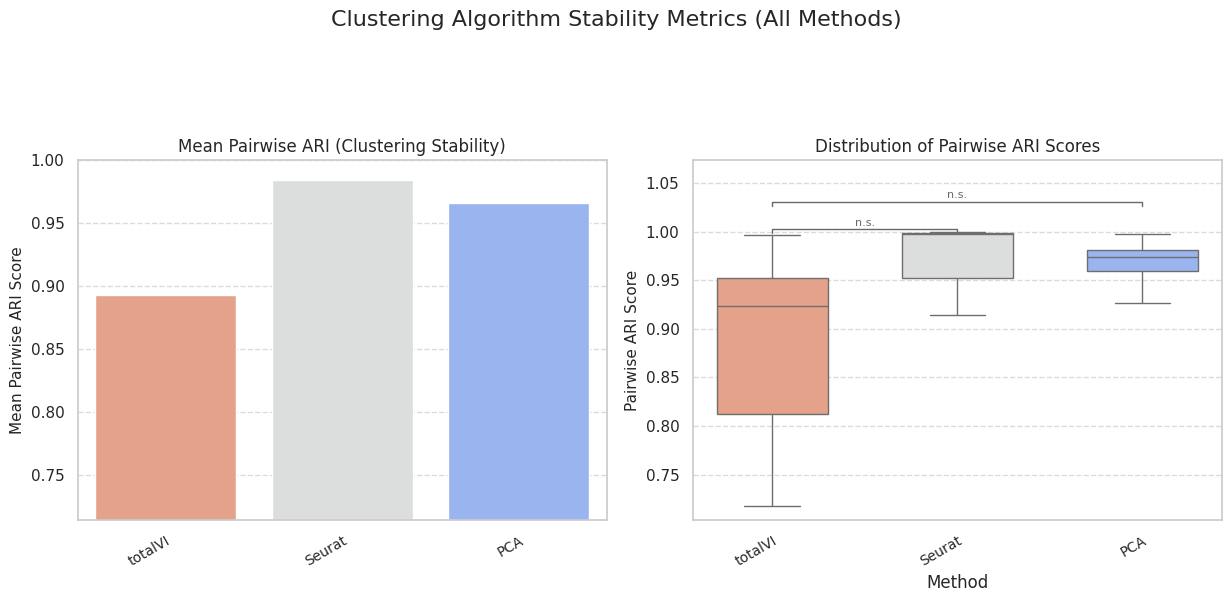

Combined clustering stability plot (adjusted bar Y-axis, boxplot stats) saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_plot_all_clustering_stability_ari_v6.png


In [22]:
# Block Benchmark-7: Visualize Clustering Stability (Adjusted Y-axis for Barplot, Restore Print)

# ... (previous code for loading and preparing all_stability_df) ...

if 'all_stability_df' not in locals() or all_stability_df.empty:
    print("Clustering stability data (all_stability_df) not found or empty. Skipping.")
else:
    all_stability_df['pairwise_ARI'] = pd.to_numeric(all_stability_df['pairwise_ARI'], errors='coerce')
    all_stability_df.dropna(subset=['pairwise_ARI'], inplace=True)

    if all_stability_df.empty or all_stability_df["method"].nunique() < 2:
        print("Not enough valid stability data or methods to generate comparison plots.")
    else:
        print("\n--- Combined Clustering Stability Pairwise ARI Scores (Summary) ---")
        stability_summary_all_df = all_stability_df.groupby("method")["pairwise_ARI"].agg(['mean', 'std', 'count']).reset_index()
        # --- PRINT THE SUMMARY DATAFRAME ---
        print(stability_summary_all_df.to_string())
        # --- END PRINT ---

        method_plot_order_final = ["totalVI", "Seurat", "PCA"]

        stability_summary_to_plot = stability_summary_all_df[
            stability_summary_all_df['method'].isin(method_plot_order_final)
        ].copy()
        if not stability_summary_to_plot.empty:
            stability_summary_to_plot.loc[:, 'method'] = pd.Categorical(
                stability_summary_to_plot['method'],
                categories=method_plot_order_final,
                ordered=True
            )
            # No need to sort here if using order parameter in barplot
        else:
            print("Warning: stability_summary_to_plot is empty after filtering.")

        all_stability_df_for_plot = all_stability_df[
            all_stability_df['method'].isin(method_plot_order_final)
        ].copy()
        if not all_stability_df_for_plot.empty:
            all_stability_df_for_plot.loc[:, 'method'] = pd.Categorical(
                all_stability_df_for_plot['method'],
                categories=method_plot_order_final,
                ordered=True
            )
        else:
             print("Warning: all_stability_df_for_plot is empty after filtering.")


        if stability_summary_to_plot.empty or all_stability_df_for_plot.empty:
            print("Not enough data after filtering for specified methods for plotting. Skipping visualization.")
        else:
            fig_stability_all, axs_stability_all = plt.subplots(1, 2, figsize=(13, 6))
            plt.subplots_adjust(wspace=0.35, bottom=0.2)

            # --- Bar Plot for Mean Pairwise ARI (Specified Order, Adjusted Y-axis) ---
            sns.barplot(x="method", y="mean", data=stability_summary_to_plot,
                        order=method_plot_order_final, # Explicitly set order
                        ax=axs_stability_all[0], palette="coolwarm_r")
            axs_stability_all[0].set_title("Mean Pairwise ARI (Clustering Stability)", fontsize=12)
            axs_stability_all[0].set_ylabel("Mean Pairwise ARI Score", fontsize=11)
            axs_stability_all[0].set_xlabel("")
            axs_stability_all[0].tick_params(axis='x', labelsize=10)
            plt.setp(axs_stability_all[0].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
            axs_stability_all[0].grid(axis='y', linestyle='--', alpha=0.7)

            # --- MODIFIED Y-axis limit for Bar Plot ---
            # Option 1: Fixed start if you know the approximate range
            # y_axis_start_bar = 0.85
            # Option 2: Slightly below the minimum mean value observed
            min_mean_ari = stability_summary_to_plot["mean"].min(skipna=True)
            y_axis_start_bar = min_mean_ari * 0.8 if pd.notna(min_mean_ari) and min_mean_ari > 0 else 0.8 # Fallback if min is 0 or negative
            y_axis_start_bar = max(0, y_axis_start_bar) # Ensure it doesn't go below 0 for ARI
            y_axis_start_bar = min(y_axis_start_bar, 0.9) # Don't let it start too high, cap at 0.9 for example

            max_y_bar_val = stability_summary_to_plot["mean"].max(skipna=True)
            # Ensure upper limit is at least a bit higher than the max bar, and not > 1.0 for ARI
            y_axis_end_bar = min(1.0, (max_y_bar_val + 0.02) if pd.notna(max_y_bar_val) else 1.0)
            if y_axis_start_bar < y_axis_end_bar : # Check if valid range
                 axs_stability_all[0].set_ylim(y_axis_start_bar, y_axis_end_bar)
            else: # Fallback to auto if calculated range is problematic
                 print(f"Warning: Calculated y_axis_start_bar ({y_axis_start_bar}) >= y_axis_end_bar ({y_axis_end_bar}). Using auto Y-limits for bar plot.")
            # --- END MODIFIED Y-axis ---


            # --- Box Plot for Distribution of Pairwise ARI with Stats (Specified Order, Dynamic Y-axis) ---
            # (Box plot Y-axis logic from previous response can remain, as it dynamically adjusts for annotations)
            sns.boxplot(x="method", y="pairwise_ARI", data=all_stability_df_for_plot,
                        order=method_plot_order_final, # Explicitly set order
                        ax=axs_stability_all[1], palette="coolwarm_r", showfliers=False, width=0.6)
            # ... (rest of box plot code, including statistical annotations, remains the same as your last working version) ...
            axs_stability_all[1].set_title("Distribution of Pairwise ARI Scores", fontsize=12)
            axs_stability_all[1].set_ylabel("Pairwise ARI Score", fontsize=11)
            axs_stability_all[1].set_xlabel("Method", fontsize=12)
            axs_stability_all[1].tick_params(axis='x', labelsize=10)
            plt.setp(axs_stability_all[1].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
            axs_stability_all[1].grid(axis='y', linestyle='--', alpha=0.7)

            target_method_stability = "totalVI"
            comparison_methods_stability = ["Seurat", "PCA"]
            if target_method_stability in all_stability_df_for_plot["method"].unique():
                data_target_stability = all_stability_df_for_plot[all_stability_df_for_plot["method"] == target_method_stability]["pairwise_ARI"].dropna()
                y_values_boxplot = all_stability_df_for_plot["pairwise_ARI"].dropna()
                if not y_values_boxplot.empty and not data_target_stability.empty:
                    y_max_boxplot = y_values_boxplot.max()
                    y_min_boxplot_actual = y_values_boxplot.min()
                    y_range_boxplot = y_max_boxplot - y_min_boxplot_actual
                    if pd.isna(y_range_boxplot) or y_range_boxplot <= 1e-6 : y_range_boxplot = abs(y_max_boxplot if pd.notna(y_max_boxplot) else 0.2) + 1e-6
                    x_coords_dict_stability = {method: i for i, method in enumerate(method_plot_order_final)}
                    x_target_boxplot = x_coords_dict_stability.get(target_method_stability)
                    if x_target_boxplot is not None:
                        bar_height_increment_box = y_range_boxplot * 0.10
                        current_bar_y_box = min(0.98, y_max_boxplot) + bar_height_increment_box * 0.8
                        for comp_method_name_box in comparison_methods_stability:
                            if comp_method_name_box in all_stability_df_for_plot["method"].unique():
                                data_comp_box = all_stability_df_for_plot[all_stability_df_for_plot["method"] == comp_method_name_box]["pairwise_ARI"].dropna()
                                if data_comp_box.empty: continue
                                p_value_box, _ = run_statistical_test(data_target_stability, data_comp_box, alternative='greater')
                                x_comp_box = x_coords_dict_stability.get(comp_method_name_box)
                                if x_comp_box is None: continue
                                if pd.notna(p_value_box):
                                    if p_value_box < 0.001: stars_box = "***"
                                    elif p_value_box < 0.01: stars_box = "**"
                                    elif p_value_box < 0.05: stars_box = "*"
                                    else: stars_box = "n.s."
                                    x1_bar_box, x2_bar_box = min(x_target_boxplot, x_comp_box), max(x_target_boxplot, x_comp_box)
                                    y_pos_for_bar_box = current_bar_y_box
                                    line_y_bottom_box = y_pos_for_bar_box - bar_height_increment_box * 0.15
                                    line_y_top_box = y_pos_for_bar_box
                                    axs_stability_all[1].plot([x1_bar_box, x1_bar_box, x2_bar_box, x2_bar_box], [line_y_bottom_box, line_y_top_box, line_y_top_box, line_y_bottom_box], lw=1.0, c='dimgray', clip_on=False)
                                    axs_stability_all[1].text((x1_bar_box + x2_bar_box) * 0.5, line_y_top_box + bar_height_increment_box * 0.05, stars_box, ha='center', va='bottom', color='dimgray', fontsize=8)
                                    current_bar_y_box += bar_height_increment_box
                current_ylim_box_auto = axs_stability_all[1].get_ylim()
                final_y_max_boxplot = current_ylim_box_auto[1]
                if 'current_bar_y_box' in locals() and pd.notna(current_bar_y_box) and current_bar_y_box > current_ylim_box_auto[1] - bar_height_increment_box * 0.5 :
                     final_y_max_boxplot = current_bar_y_box + bar_height_increment_box * 0.5
                y_min_boxplot_data = y_values_boxplot.min()
                final_y_min_boxplot = y_min_boxplot_data * 0.98 if pd.notna(y_min_boxplot_data) and y_min_boxplot_data >= 0 else (y_min_boxplot_data * 1.02 if pd.notna(y_min_boxplot_data) else current_ylim_box_auto[0])
                axs_stability_all[1].set_ylim(final_y_min_boxplot, final_y_max_boxplot)

            fig_stability_all.suptitle("Clustering Algorithm Stability Metrics (All Methods)", fontsize=16, y=1.05)
            plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.93])

            all_stability_plot_path_v6 = os.path.join(benchmark_figure_dir, "benchmark_plot_all_clustering_stability_ari_v6.png") # New filename
            plt.savefig(all_stability_plot_path_v6, dpi=300)
            plt.show()
            plt.close(fig_stability_all)
            print(f"Combined clustering stability plot (adjusted bar Y-axis, boxplot stats) saved to: {all_stability_plot_path_v6}")


In [5]:
# Block Benchmark-8a: Load RNA-Protein Mapping and Prepare Baseline Expression Data

print("\n--- Benchmark Metric 3: RNA-Protein Pair Correlation ---")
print("--- Loading RNA-Protein Mapping and Preparing Baseline Data ---")

# --- Initialize Dictionaries to store expression data for all methods ---
# This should ideally be done once at the beginning of your benchmark script,
# or ensure they are loaded if defined in a previous, successfully run block.
# For safety, we initialize them here if they might not exist.

if 'expression_data_for_viz' not in locals():
    expression_data_for_viz = {} # Stores RNA expression DataFrames
    print("Initialized 'expression_data_for_viz' dictionary.")

if 'protein_data_for_corr' not in locals():
    protein_data_for_corr = {}   # Stores Protein expression DataFrames
    print("Initialized 'protein_data_for_corr' dictionary.")

# --- Load RNA-Protein Mapping File ---
rna_protein_map_path = "/content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/data/RNA_Protein_match.csv" # Your path
if not os.path.exists(rna_protein_map_path):
    raise FileNotFoundError(f"RNA-Protein mapping file not found at: {rna_protein_map_path}")

# MODIFICATION: Specify the delimiter as tab
rna_protein_df_map = pd.read_csv(rna_protein_map_path, sep='\t')
print(f"Loaded RNA-Protein mapping table. Shape: {rna_protein_df_map.shape}. Head:")
print(rna_protein_df_map.head())

# Ensure column names are 'RNA' and 'Protein' as per your example
if not all(col in rna_protein_df_map.columns for col in ["RNA", "Protein"]):
    # Try stripping whitespace from column names if there's an issue
    rna_protein_df_map.columns = rna_protein_df_map.columns.str.strip()
    if not all(col in rna_protein_df_map.columns for col in ["RNA", "Protein"]):
        print(f"Actual columns found: {rna_protein_df_map.columns.tolist()}")
        raise ValueError("RNA-Protein mapping CSV must contain 'RNA' and 'Protein' columns even after stripping whitespace. Check the CSV file header and separator.")
else:
    print("RNA and Protein columns found in mapping table.")



--- Benchmark Metric 3: RNA-Protein Pair Correlation ---
--- Loading RNA-Protein Mapping and Preparing Baseline Data ---
Initialized 'expression_data_for_viz' dictionary.
Initialized 'protein_data_for_corr' dictionary.
Loaded RNA-Protein mapping table. Shape: (30, 2). Head:
    RNA        Protein
0   CD3  CD3_TotalSeqB
1   T3D  CD3_TotalSeqB
2  OKT3  CD3_TotalSeqB
3   T3E  CD3_TotalSeqB
4   T3G  CD3_TotalSeqB
RNA and Protein columns found in mapping table.


In [6]:
# --- Prepare Baseline RNA Expression Data ---
# Path to the directory containing matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz for raw HVG RNA counts
raw_counts_rna_dir = os.path.join(preprocessed_data_main_dir, 'pbmc10k_for_SeuratPCA_preprocessed/rna_hvg_counts_mtx/')

if not os.path.isdir(raw_counts_rna_dir):
    print(f"WARNING: Raw RNA MTX directory not found: {raw_counts_rna_dir}. Baseline RNA correlation will be skipped.")
    baseline_rna_expr = pd.DataFrame(index=benchmark_df.index) # Create empty df with correct index for consistency
else:
    print(f"\nLoading raw HVG RNA counts from: {raw_counts_rna_dir}")
    adata_rna_raw_baseline = sc.read_10x_mtx(raw_counts_rna_dir, var_names='gene_symbols', cache=False)
    adata_rna_raw_baseline.var_names_make_unique() # Ensure gene names are unique

    print(f"  Loaded adata_rna_raw_baseline. Initial obs_names head: {adata_rna_raw_baseline.obs_names[:5].tolist()}")
    print(f"  benchmark_df.index head: {benchmark_df.index[:5].tolist()}")

    # --- Barcode Alignment ---
    # DO NOT remove suffix from adata_rna_raw_baseline.obs_names.
    # Both benchmark_df.index and adata_rna_raw_baseline.obs_names should now have the "-1" suffix (or similar).

    # We will now subset adata_rna_raw_baseline to only include cells that are in benchmark_df.index
    # and ensure the order is the same.
    # benchmark_df.index contains the barcodes of cells that passed all QC.

    # Check which barcodes from benchmark_df.index are actually present in adata_rna_raw_baseline.obs_names
    # Ideally, all should be present if rna_hvg_counts_mtx was derived from a superset of cells.
    common_barcodes_for_alignment = benchmark_df.index.intersection(adata_rna_raw_baseline.obs_names)

    if len(common_barcodes_for_alignment) < len(benchmark_df.index):
        print(f"  WARNING: {len(benchmark_df.index) - len(common_barcodes_for_alignment)} cells from benchmark_df.index "
              "were NOT found in adata_rna_raw_baseline.obs_names. These cells will have NaN/0 in baseline RNA.")

    if len(common_barcodes_for_alignment) == 0:
        print("  ERROR: No common barcodes found between benchmark_df and adata_rna_raw_baseline. Cannot create baseline RNA.")
        baseline_rna_expr = pd.DataFrame(index=benchmark_df.index, columns=rna_protein_df_map["RNA"].unique()) # Empty
    else:
        # Subset to common cells first, then reindex to benchmark_df's order and fill missing
        adata_rna_raw_baseline_common = adata_rna_raw_baseline[common_barcodes_for_alignment, :].copy()

        print(f"  Subsetted adata_rna_raw_baseline to {adata_rna_raw_baseline_common.n_obs} common cells.")

        # Basic normalization for baseline RNA
        sc.pp.normalize_total(adata_rna_raw_baseline_common, target_sum=1e4)
        sc.pp.log1p(adata_rna_raw_baseline_common)

        # Create DataFrame and then reindex to match benchmark_df exactly, filling non-commons with 0
        baseline_rna_expr_temp = pd.DataFrame(
            adata_rna_raw_baseline_common.X.toarray() if hasattr(adata_rna_raw_baseline_common.X, "toarray") else adata_rna_raw_baseline_common.X,
            index=adata_rna_raw_baseline_common.obs_names,
            columns=adata_rna_raw_baseline_common.var_names
        )
        baseline_rna_expr = baseline_rna_expr_temp.reindex(benchmark_df.index).fillna(0)
        print(f"  Processed baseline RNA expression, shape aligned to benchmark_df: {baseline_rna_expr.shape}")
        if baseline_rna_expr.isnull().sum().sum() > 0 : # Should be 0 due to fillna(0)
             print(f"  Warning: NaNs still present in baseline_rna_expr after reindex and fillna: {baseline_rna_expr.isnull().sum().sum()}")


# --- Prepare Baseline Protein Expression Data ---
# (Path definition for raw_counts_protein_path should be here from your original Block 8a)
raw_counts_protein_path = os.path.join(preprocessed_data_main_dir, 'pbmc10k_for_SeuratPCA_preprocessed/protein_counts_raw.csv')

if not os.path.exists(raw_counts_protein_path):
    print(f"WARNING: Raw Protein CSV not found: {raw_counts_protein_path}. Baseline Protein correlation will be skipped.")
    baseline_protein_expr = pd.DataFrame(index=benchmark_df.index) # Empty
else:
    print(f"\nLoading raw Protein counts from: {raw_counts_protein_path}")
    baseline_protein_df_raw = pd.read_csv(raw_counts_protein_path, index_col=0) # Assumes first col is cell barcode
    # Ensure index matches benchmark_df (it should if from same preprocessing run)

    # Align to benchmark_df cells, filling missing with 0
    baseline_protein_expr_temp = baseline_protein_df_raw.reindex(benchmark_df.index.intersection(baseline_protein_df_raw.index))
    baseline_protein_expr = baseline_protein_expr_temp.reindex(benchmark_df.index).fillna(0)

    # Basic normalization for baseline Protein (e.g., log1p)
    baseline_protein_expr = np.log1p(baseline_protein_expr) # Apply log1p AFTER ensuring correct cells and filling NaNs
    print(f"  Processed baseline Protein expression, shape aligned to benchmark_df: {baseline_protein_expr.shape}")
    if baseline_protein_expr.isnull().sum().sum() > 0 :
        print(f"  Warning: NaNs present in baseline_protein_expr: {baseline_protein_expr.isnull().sum().sum()}")


# --- Update dictionaries for subsequent correlation calculation ---
expression_data_for_viz["Baseline_RNA"] = baseline_rna_expr
protein_data_for_corr["Baseline_Protein"] = baseline_protein_expr # Assuming protein_data_for_corr was initialized in Block 8a

print("\nBlock Benchmark-8a finished: RNA-Protein map loaded and baseline expression data prepared and aligned.")


Loading raw HVG RNA counts from: /content/drive/My Drive/CMML_ICA2/Data_Preprocessing_Outputs/data_pbmc10k_mtx/processed/pbmc10k_for_SeuratPCA_preprocessed/rna_hvg_counts_mtx/
  Loaded adata_rna_raw_baseline. Initial obs_names head: ['AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1', 'AAACCCAGTATCGAAA-1', 'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1']
  benchmark_df.index head: ['AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1', 'AAACCCAGTATCGAAA-1', 'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1']
  Subsetted adata_rna_raw_baseline to 7611 common cells.
  Processed baseline RNA expression, shape aligned to benchmark_df: (7611, 4000)

Loading raw Protein counts from: /content/drive/My Drive/CMML_ICA2/Data_Preprocessing_Outputs/data_pbmc10k_mtx/processed/pbmc10k_for_SeuratPCA_preprocessed/protein_counts_raw.csv
  Processed baseline Protein expression, shape aligned to benchmark_df: (7611, 17)

Block Benchmark-8a finished: RNA-Protein map loaded and baseline expression data prepared and aligned.


In [7]:
# --- Also add the other methods' data to these dictionaries if they were loaded in Block 3 ---
if 'totalvi_denoised_rna_df' in locals() and not totalvi_denoised_rna_df.empty:
    expression_data_for_viz["totalVI"] = totalvi_denoised_rna_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added totalVI RNA to dict, shape: {expression_data_for_viz['totalVI'].shape}")
else:
    print("  Warning: totalvi_denoised_rna_df not found or empty. Will be skipped in correlation.")

if 'totalvi_denoised_protein_df' in locals() and not totalvi_denoised_protein_df.empty:
    protein_data_for_corr["totalVI"] = totalvi_denoised_protein_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added totalVI Protein to dict, shape: {protein_data_for_corr['totalVI'].shape}")
else:
    print("  Warning: totalvi_denoised_protein_df not found or empty. Will be skipped in correlation.")


if 'seurat_rna_df' in locals() and not seurat_rna_df.empty:
    expression_data_for_viz["Seurat"] = seurat_rna_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added Seurat RNA to dict, shape: {expression_data_for_viz['Seurat'].shape}")
else:
    print("  Warning: seurat_rna_df not found or empty. Will be skipped in correlation.")

if 'seurat_protein_df' in locals() and not seurat_protein_df.empty:
    protein_data_for_corr["Seurat"] = seurat_protein_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added Seurat Protein to dict, shape: {protein_data_for_corr['Seurat'].shape}")
else:
    print("  Warning: seurat_protein_df not found or empty. Will be skipped in correlation.")


if 'pca_rna_df' in locals() and not pca_rna_df.empty:
    expression_data_for_viz["PCA"] = pca_rna_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added PCA RNA to dict, shape: {expression_data_for_viz['PCA'].shape}")
else:
    print("  Warning: pca_rna_df not found or empty. Will be skipped in correlation.")

if 'pca_protein_df' in locals() and not pca_protein_df.empty:
    protein_data_for_corr["PCA"] = pca_protein_df.reindex(benchmark_df.index).fillna(0)
    print(f"  Added PCA Protein to dict, shape: {protein_data_for_corr['PCA'].shape}")
else:
    print("  Warning: pca_protein_df not found or empty. Will be skipped in correlation.")

print("\nBlock Benchmark-8a finished: RNA-Protein map loaded and ALL expression data prepared and aligned in dictionaries.")
print("\nexpression_data_for_viz keys:", list(expression_data_for_viz.keys()))
print("protein_data_for_corr keys:", list(protein_data_for_corr.keys()))

  Added totalVI RNA to dict, shape: (7611, 4000)
  Added totalVI Protein to dict, shape: (7611, 17)
  Added Seurat RNA to dict, shape: (7611, 3000)
  Added Seurat Protein to dict, shape: (7611, 17)
  Added PCA RNA to dict, shape: (7611, 4000)
  Added PCA Protein to dict, shape: (7611, 17)

Block Benchmark-8a finished: RNA-Protein map loaded and ALL expression data prepared and aligned in dictionaries.

expression_data_for_viz keys: ['Baseline_RNA', 'totalVI', 'Seurat', 'PCA']
protein_data_for_corr keys: ['Baseline_Protein', 'totalVI', 'Seurat', 'PCA']


In [8]:
# Block Benchmark-8b: Filter Valid RNA-Protein Pairs and Calculate Correlations

print("\n--- Filtering valid RNA-Protein pairs and calculating correlations ---")

all_methods_correlations = [] # List to store DataFrames of correlations for each method

# Methods for which we have RNA and Protein expression data
# Note: For baseline, RNA is in expression_data_for_viz["Baseline_RNA"]
#       and Protein is in protein_data_for_corr["Baseline_Protein"]
methods_for_correlation = ["Baseline", "totalVI", "Seurat", "PCA"] # Add "Baseline"

for method_name in methods_for_correlation:
    print(f"\nProcessing correlations for method: {method_name}")

    # Get the correct expression DataFrames for the current method
    if method_name == "Baseline":
        current_rna_expr = expression_data_for_viz.get("Baseline_RNA", pd.DataFrame())
        current_protein_expr = protein_data_for_corr.get("Baseline_Protein", pd.DataFrame())
    else:
        current_rna_expr = expression_data_for_viz.get(method_name, pd.DataFrame())
        current_protein_expr = protein_data_for_corr.get(method_name, pd.DataFrame())

    if method_name == "Seurat":
        print(f"  --- Debugging Seurat ({method_name}) ---")
        print(f"    First 5 RNA column names from Seurat's expression data (current_rna_expr.columns):")
        if not current_rna_expr.empty:
            print(f"      {current_rna_expr.columns[:5].tolist()}")
            print(f"      Example RNA symbol from map: '{rna_protein_df_map['RNA'].iloc[0]}'")
            if rna_protein_df_map['RNA'].iloc[0] in current_rna_expr.columns:
                print(f"      MATCH FOUND for example RNA symbol.")
            else:
                print(f"      NO MATCH for example RNA symbol.")
        else:
            print("      Seurat RNA expression data is empty.")

        print(f"    First 5 Protein column names from Seurat's expression data (current_protein_expr.columns):")
        if not current_protein_expr.empty:
            print(f"      {current_protein_expr.columns[:5].tolist()}")
            print(f"      Example Protein name from map: '{rna_protein_df_map['Protein'].iloc[0]}'")
            if rna_protein_df_map['Protein'].iloc[0] in current_protein_expr.columns:
                print(f"      MATCH FOUND for example Protein name.")
            else:
                print(f"      NO MATCH for example Protein name.")
        else:
            print("      Seurat Protein expression data is empty.")
        print(f"  --- End Debugging Seurat ---")

    if current_rna_expr.empty or current_protein_expr.empty:
        print(f"  RNA or Protein expression data missing for method {method_name}. Skipping.")
        continue

    method_pair_correlations = []
    processed_pairs = set() # To handle one protein mapping to multiple RNAs (if only one RNA exists)

    for _, row in rna_protein_df_map.iterrows():
        rna_symbol = row["RNA"]
        protein_name = row["Protein"]

        # Create a unique key for the pair, as one protein might map to multiple RNAs
        # but we only want to calculate for one existing RNA if multiple are listed for one protein.
        # Or, if one RNA maps to one Protein, and that RNA is listed multiple times for that protein,
        # we only process it once.
        # For "one protein -> multiple RNAs in map": if rna_symbol exists, we use it.
        # If multiple rna_symbols in map exist for the same protein, we'll get multiple entries.

        pair_key = (rna_symbol, protein_name) # Use this if you want all listed pairs if RNA exists

        if rna_symbol in current_rna_expr.columns and \
           protein_name in current_protein_expr.columns:

            # Ensure no NaN values in the series before correlation
            rna_values = current_rna_expr[rna_symbol].dropna()
            protein_values = current_protein_expr[protein_name].dropna()

            # Align by cell index
            common_corr_index = rna_values.index.intersection(protein_values.index)
            if len(common_corr_index) < 2: # Need at least 2 data points for correlation
                # print(f"  Pair ({rna_symbol}, {protein_name}): Not enough common non-NaN samples. Skipping.")
                continue

            rna_aligned = rna_values.loc[common_corr_index]
            protein_aligned = protein_values.loc[common_corr_index]

            if len(rna_aligned) < 2: # Check again after alignment
                continue

            try:
                pearson_corr, _ = pearsonr(rna_aligned, protein_aligned)
                spearman_corr, _ = spearmanr(rna_aligned, protein_aligned)
            except ValueError: # If all values are constant after alignment/dropna
                # print(f"  Pair ({rna_symbol}, {protein_name}): Constant values, correlation undefined. Skipping.")
                pearson_corr, spearman_corr = np.nan, np.nan


            method_pair_correlations.append({
                "method": method_name,
                "RNA": rna_symbol,
                "Protein": protein_name,
                "Pearson_Correlation": pearson_corr,
                "Spearman_Correlation": spearman_corr,
                "n_common_cells": len(common_corr_index)
            })
        # else:
            # print(f"  Pair ({rna_symbol}, {protein_name}): RNA or Protein not found in expression data for {method_name}. Skipping.")

    if method_pair_correlations:
        method_corr_df = pd.DataFrame(method_pair_correlations)
        all_methods_correlations.append(method_corr_df)
        print(f"  Calculated correlations for {len(method_corr_df)} valid pairs for {method_name}.")
        print(method_corr_df.head())
    else:
        print(f"  No valid RNA-Protein pairs found or processed for {method_name}.")

# Concatenate all results into one DataFrame
if all_methods_correlations:
    benchmark_correlation_df = pd.concat(all_methods_correlations, ignore_index=True)
    print("\n--- Combined RNA-Protein Correlation Results ---")
    print(benchmark_correlation_df.head())

    correlation_csv_path = os.path.join(benchmark_data_dir, "benchmark_rna_protein_correlations.csv")
    benchmark_correlation_df.to_csv(correlation_csv_path, index=False)
    print(f"RNA-Protein correlation results saved to: {correlation_csv_path}")
else:
    print("No correlation data generated across all methods.")
    benchmark_correlation_df = pd.DataFrame() # Empty df for next block

print("\nBlock Benchmark-8b finished: RNA-Protein Correlation Calculation.")


--- Filtering valid RNA-Protein pairs and calculating correlations ---

Processing correlations for method: Baseline
  Calculated correlations for 9 valid pairs for Baseline.
     method     RNA         Protein  Pearson_Correlation  \
0  Baseline     CD4   CD4_TotalSeqB             0.336639   
1  Baseline     MAL  CD8a_TotalSeqB             0.024660   
2  Baseline    CD14  CD14_TotalSeqB             0.918102   
3  Baseline  FCGR3A  CD16_TotalSeqB             0.667282   
4  Baseline   NCAM1  CD56_TotalSeqB             0.326040   

   Spearman_Correlation  n_common_cells  
0              0.302041            7611  
1              0.085242            7611  
2              0.733032            7611  
3              0.519373            7611  
4              0.239563            7611  

Processing correlations for method: totalVI
  Calculated correlations for 9 valid pairs for totalVI.
    method     RNA         Protein  Pearson_Correlation  Spearman_Correlation  \
0  totalVI     MAL  CD8a_Tot

Methods to be plotted in order: ['totalVI', 'Seurat', 'PCA']

--- Statistical Test P-values (totalVI vs Others, alternative='greater') ---
  P-values for Pearson_Correlation (totalVI vs other methods):
    totalVI vs Seurat: p-value = 0.14465741619099387
    totalVI vs PCA: p-value = 0.1656935481238075


<ipython-input-18-183a77dcb07e>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="method", y=corr_type, data=correlation_df_to_plot,
<ipython-input-18-183a77dcb07e>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="method", y=corr_type, data=correlation_df_to_plot,


  P-values for Spearman_Correlation (totalVI vs other methods):
    totalVI vs Seurat: p-value = 0.017034597572071968
    totalVI vs PCA: p-value = 0.017034597572071968


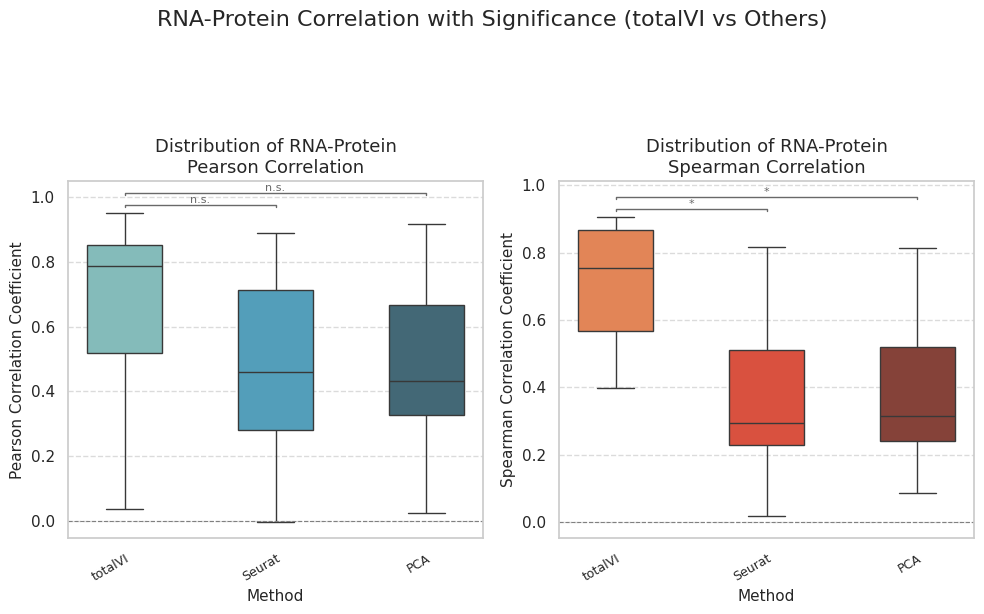

RNA-Protein correlation plot with stats (no Baseline) saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_plot_rna_protein_correlation_stats_final.png


In [18]:
if 'benchmark_correlation_df' not in locals() or benchmark_correlation_df.empty:
    print("No correlation data available for visualization. Skipping.")
elif benchmark_correlation_df["method"].nunique() < 1 :
    print("No methods with correlation data to plot. Skipping.")
else:
    methods_to_plot_correlation = ["totalVI", "Seurat", "PCA"]

    correlation_df_to_plot = benchmark_correlation_df[
        benchmark_correlation_df["method"].isin(methods_to_plot_correlation)
    ].copy()

    # --- Ensure 'method' is categorical WITH THE CORRECT ORDER ---
    if not correlation_df_to_plot.empty:
        # Create the categorical type with the desired order
        method_categorical_type = pd.CategoricalDtype(categories=methods_to_plot_correlation, ordered=True)
        # Apply this categorical type to the 'method' column
        correlation_df_to_plot.loc[:, "method"] = correlation_df_to_plot["method"].astype(method_categorical_type)

        # Now, drop any rows where 'method' became NaN due toastype (if a method was in original df but not in categories)
        # This also handles cases where some methods in methods_to_plot_correlation might not be in the data.
        correlation_df_to_plot.dropna(subset=['method'], inplace=True)

        # Sort the DataFrame by this categorical 'method' column to ensure plots respect the order if not using 'order' param
        # correlation_df_to_plot.sort_values("method", inplace=True) # Optional if using order in sns plots

        # Get the actual categories present in the data, in the specified order
        if isinstance(correlation_df_to_plot["method"].dtype, pd.CategoricalDtype):
            actual_methods_in_plot_df = correlation_df_to_plot["method"].cat.categories.tolist()
            # Further filter this list to only those methods that actually have data rows after dropna
            actual_methods_in_plot_df = [m for m in actual_methods_in_plot_df if m in correlation_df_to_plot["method"].unique()]
        else:
            # Fallback if still not categorical (should not happen with astype)
            print("Warning: 'method' column did not convert to CategoricalDtype as expected.")
            actual_methods_in_plot_df = correlation_df_to_plot["method"].unique().tolist()
            # Try to sort actual_methods_in_plot_df according to methods_to_plot_correlation
            actual_methods_in_plot_df = [m for m in methods_to_plot_correlation if m in actual_methods_in_plot_df]

        print(f"Methods to be plotted in order: {actual_methods_in_plot_df}")
    else:
        actual_methods_in_plot_df = [] # Empty list if dataframe is empty

    if not actual_methods_in_plot_df or len(actual_methods_in_plot_df) < 1:
        print("Not enough data or methods for plotting after filtering. Skipping visualization.")
    else:
        # ... (rest of your Block Benchmark-8c code for plotting and stats,
        #      using actual_methods_in_plot_df for the 'order' parameter in sns.boxplot/barplot
        #      and for x_coords_dict_corr for stat annotations) ...

        # Example usage for sns.boxplot:
        # sns.boxplot(x="method", y=corr_type, data=correlation_df_to_plot,
        #             order=actual_methods_in_plot_df, # Use this ordered list
        #             palette=current_palette_dict,
        #             ax=ax, showfliers=False, width=0.5)

        # For x_coords_dict_corr for stat annotations:
        # x_coords_dict_corr = {method: i for i, method in enumerate(actual_methods_in_plot_df)}

        # --- (The rest of your plotting and stats code from the previous correct version) ---
        # Make sure to use `actual_methods_in_plot_df` for the `order` parameter in seaborn plots
        # and for generating `x_coords_dict_corr`.
        from scipy.stats import mannwhitneyu

        target_method_corr = "totalVI"
        comparison_methods_corr = [m for m in actual_methods_in_plot_df if m != target_method_corr]

        fig_corr_stats_no_baseline, axs_corr_stats_no_baseline = plt.subplots(1, 2, figsize=(10, 6))
        plt.subplots_adjust(wspace=0.35, bottom=0.15)

        correlation_types_titles = {
            "Pearson_Correlation": "Pearson Correlation",
            "Spearman_Correlation": "Spearman Correlation"
        }
        palettes_stats = {"Pearson_Correlation": "GnBu_d", "Spearman_Correlation": "YlOrRd_d"}

        print(f"\n--- Statistical Test P-values ({target_method_corr} vs Others, alternative='greater') ---")

        for idx, (corr_type, plot_title_suffix) in enumerate(correlation_types_titles.items()):
            ax = axs_corr_stats_no_baseline[idx]

            current_palette_dict = { # Create palette based on actual methods present and in order
                method: color for method, color in zip(actual_methods_in_plot_df, sns.color_palette(palettes_stats[corr_type], n_colors=len(actual_methods_in_plot_df)))
            }

            sns.boxplot(x="method", y=corr_type, data=correlation_df_to_plot,
                        order=actual_methods_in_plot_df, # Use the ordered list
                        palette=current_palette_dict,
                        ax=ax, showfliers=False, width=0.5)

            ax.set_title(f"Distribution of RNA-Protein\n{plot_title_suffix}", fontsize=13)
            ax.set_ylabel(f"{plot_title_suffix} Coefficient", fontsize=11)
            ax.set_xlabel("Method", fontsize=11)
            ax.tick_params(axis='x', labelsize=9)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.axhline(0, color='grey', linestyle='--', lw=0.8)

            if target_method_corr in actual_methods_in_plot_df: # Check if target is in data
                data_target_corr = correlation_df_to_plot[
                    (correlation_df_to_plot["method"] == target_method_corr)
                ][corr_type].dropna()

                y_values_for_current_plot = correlation_df_to_plot[correlation_df_to_plot["method"].isin(actual_methods_in_plot_df)][corr_type].dropna()
                if y_values_for_current_plot.empty or data_target_corr.empty: continue

                y_max_plot = y_values_for_current_plot.max()
                y_min_plot = y_values_for_current_plot.min()
                y_range_plot = y_max_plot - y_min_plot
                if pd.isna(y_range_plot) or y_range_plot <= 1e-6 : y_range_plot = abs(y_max_plot if pd.notna(y_max_plot) else 0.5) + 1e-6

                x_coords_dict_corr = {method: i for i, method in enumerate(actual_methods_in_plot_df)}
                x_target_corr = x_coords_dict_corr.get(target_method_corr)
                if x_target_corr is None: continue

                bar_height_increment_corr = y_range_plot * 0.04
                current_bar_y_corr = min(0.99, y_max_plot if pd.notna(y_max_plot) else 0.99) + bar_height_increment_corr * 0.6

                print(f"  P-values for {corr_type} ({target_method_corr} vs other methods):")
                for comp_method_name_corr in comparison_methods_corr:
                    if comp_method_name_corr in actual_methods_in_plot_df:
                        data_comp_corr = correlation_df_to_plot[
                            (correlation_df_to_plot["method"] == comp_method_name_corr)
                        ][corr_type].dropna()

                        if data_comp_corr.empty: continue
                        p_value_corr, error_msg_corr = run_statistical_test(data_target_corr, data_comp_corr, alternative='greater')
                        print(f"    {target_method_corr} vs {comp_method_name_corr}: p-value = {p_value_corr if pd.notna(p_value_corr) else f'Error/NA ({error_msg_corr})'}")

                        x_comp_corr = x_coords_dict_corr.get(comp_method_name_corr)
                        if x_comp_corr is None: continue

                        if pd.notna(p_value_corr):
                            if p_value_corr < 0.001: stars = "***"
                            elif p_value_corr < 0.01: stars = "**"
                            elif p_value_corr < 0.05: stars = "*"
                            else: stars = "n.s."

                            x1_bar, x2_bar = min(x_target_corr, x_comp_corr), max(x_target_corr, x_comp_corr)
                            y_pos_for_bar = current_bar_y_corr
                            line_y_bottom = y_pos_for_bar - bar_height_increment_corr * 0.15
                            line_y_top = y_pos_for_bar

                            ax.plot([x1_bar, x1_bar, x2_bar, x2_bar],
                                    [line_y_bottom, line_y_top, line_y_top, line_y_bottom],
                                    lw=1.0, c='dimgray', clip_on=False)
                            ax.text((x1_bar + x2_bar) * 0.5, line_y_top + bar_height_increment_corr * 0.02, stars,
                                    ha='center', va='bottom', color='dimgray', fontsize=8)
                            current_bar_y_corr += bar_height_increment_corr

                current_ylim = ax.get_ylim()
                final_y_max = current_ylim[1]
                if 'current_bar_y_corr' in locals() and pd.notna(current_bar_y_corr) and current_bar_y_corr > (current_ylim[1] - bar_height_increment_corr * 0.2) :
                     final_y_max = current_bar_y_corr + bar_height_increment_corr * 0.3
                ax.set_ylim(current_ylim[0], min(1.05, final_y_max))

        fig_corr_stats_no_baseline.suptitle(f"RNA-Protein Correlation with Significance ({target_method_corr} vs Others)", fontsize=16, y=1.05)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])

        corr_stats_plot_final_path = os.path.join(benchmark_figure_dir, "benchmark_plot_rna_protein_correlation_stats_final.png")
        plt.savefig(corr_stats_plot_final_path, dpi=300)
        plt.show()
        plt.close(fig_corr_stats_no_baseline)
        print(f"RNA-Protein correlation plot with stats (no Baseline) saved to: {corr_stats_plot_final_path}")

# This final print statement was outside the main if, moving it inside
# print("\nBlock Benchmark-8c finished: RNA-Protein Correlation Visualization (totalVI, Seurat, PCA with Stats - Corrected).")


--- Generating Scatter Plots: Method vs PCA Pearson Correlations ---
For totalVI vs PCA: Package 'adjustText' not installed. Annotations might overlap.
For Seurat vs PCA: Package 'adjustText' not installed. Annotations might overlap.


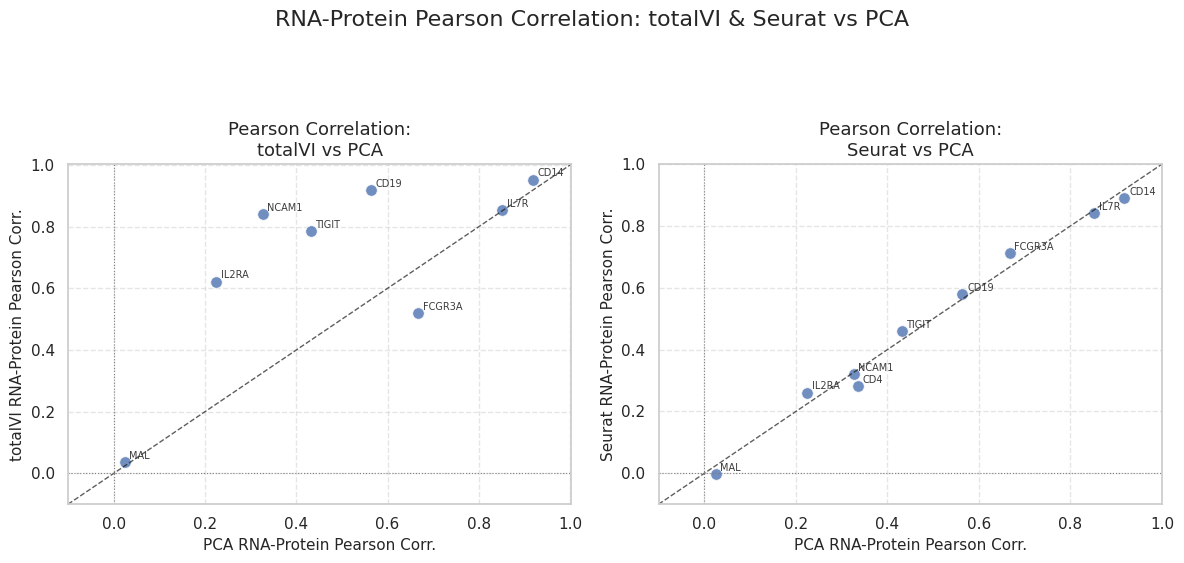

Scatter plots of Methods vs PCA correlations saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_plot_scatter_corr_vs_PCA.png

Block Benchmark-8c finished: RNA-Protein Correlation Visualization (Revised Scatter vs PCA).


In [19]:
# Block Benchmark-8c: Visualize RNA-Protein Correlations (Revised Scatter Plots - Method vs PCA)

# ... (previous code for loading benchmark_correlation_df and plotting distribution boxplots) ...
# Ensure benchmark_correlation_df contains "method", "RNA", "Protein", "Pearson_Correlation"

print("\n--- Generating Scatter Plots: Method vs PCA Pearson Correlations ---")

# Methods to compare against PCA
methods_to_compare_with_pca = ["totalVI", "Seurat"]
pca_method_name = "PCA" # PCA is now the reference for these scatter plots

# Prepare PCA's correlations for joining
if pca_method_name in benchmark_correlation_df["method"].unique():
    df_pca_corr_scatter = benchmark_correlation_df[
        benchmark_correlation_df["method"] == pca_method_name
    ].set_index(["RNA", "Protein"])[["Pearson_Correlation"]] # Select only Pearson and set index
else:
    print(f"ERROR: PCA method ('{pca_method_name}') not found in correlation data. Cannot create scatter plots vs PCA.")
    df_pca_corr_scatter = None


if df_pca_corr_scatter is not None and not df_pca_corr_scatter.empty:
    num_comparison_methods = len(methods_to_compare_with_pca)
    if num_comparison_methods == 0:
        print("No methods specified to compare against PCA. Skipping scatter plots.")
    else:
        fig_scatter_vs_pca, axes_scatter_vs_pca = plt.subplots(1, num_comparison_methods,
                                                               figsize=(6 * num_comparison_methods, 5.5),
                                                               squeeze=False) # Ensure axes is always 2D array for indexing

        plt.subplots_adjust(wspace=0.35)

        for idx, current_method_name in enumerate(methods_to_compare_with_pca):
            ax = axes_scatter_vs_pca[0, idx] # axes_scatter_vs_pca is now 2D

            if current_method_name not in benchmark_correlation_df["method"].unique():
                print(f"Method '{current_method_name}' not found in correlation data. Skipping its scatter plot.")
                ax.text(0.5, 0.5, f"{current_method_name}\nData N/A", ha='center', va='center', fontsize=10, color='red')
                ax.set_title(f"Pearson Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.set_xlabel(f"{pca_method_name} RNA-Protein Pearson Corr.", fontsize=11)
                ax.set_ylabel(f"{current_method_name} RNA-Protein Pearson Corr.", fontsize=11)
                ax.grid(True, linestyle='--', alpha=0.5)
                ax.plot([0, 1], [0, 1], 'k--', lw=1)
                ax.set_xlim(-0.1, 1.05)
                ax.set_ylim(-0.1, 1.05)
                continue

            df_current_method_corr = benchmark_correlation_df[
                benchmark_correlation_df["method"] == current_method_name
            ].set_index(["RNA", "Protein"])[["Pearson_Correlation"]]

            # Merge with PCA's correlations
            merged_corr_for_plot_vs_pca = df_current_method_corr.join(
                df_pca_corr_scatter,
                lsuffix=f'_{current_method_name}',
                rsuffix=f'_{pca_method_name}',
                how='inner' # Only pairs present in both
            )

            # Rename columns for clarity
            col_current_method = f"Pearson_Correlation_{current_method_name}"
            col_pca_ref = f"Pearson_Correlation_{pca_method_name}"
            merged_corr_for_plot_vs_pca.rename(
                columns={col_current_method: "current_method_corr", col_pca_ref: "pca_ref_corr"},
                inplace=True
            )

            if not merged_corr_for_plot_vs_pca.empty:
                sns.scatterplot(x="pca_ref_corr", y="current_method_corr",
                                data=merged_corr_for_plot_vs_pca, alpha=0.8, s=70, ax=ax, legend=False)

                texts = []
                for rna_protein_pair_idx, row_data in merged_corr_for_plot_vs_pca.iterrows():
                    rna_name_label = rna_protein_pair_idx[0] # RNA name from tuple index
                    texts.append(ax.text(row_data["pca_ref_corr"] + 0.01, row_data["current_method_corr"] + 0.01,
                                         rna_name_label, fontsize=7, alpha=0.9))

                # Optional: adjust_text to prevent label overlap
                try:
                    from adjustText import adjust_text
                    adjust_text(texts, ax=ax,Lim_points=50,force_points=0.1, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5,alpha=0.5))
                except ImportError:
                    print(f"For {current_method_name} vs PCA: Package 'adjustText' not installed. Annotations might overlap.")

                all_values_plot = pd.concat([merged_corr_for_plot_vs_pca["pca_ref_corr"], merged_corr_for_plot_vs_pca["current_method_corr"]]).dropna()
                if not all_values_plot.empty:
                    min_val_p = min(-0.1, all_values_plot.min() - 0.05)
                    max_val_p = max(1.0, all_values_plot.max() + 0.05)
                    ax.plot([min_val_p, max_val_p], [min_val_p, max_val_p], 'k--', lw=1, alpha=0.7)
                    ax.set_xlim(min_val_p, max_val_p)
                    ax.set_ylim(min_val_p, max_val_p)
                else:
                    ax.plot([-0.1, 1], [-0.1, 1], 'k--', lw=1, alpha=0.7)
                    ax.set_xlim(-0.1, 1.05)
                    ax.set_ylim(-0.1, 1.05)

                ax.axhline(0, color='grey', linestyle=':', lw=0.8)
                ax.axvline(0, color='grey', linestyle=':', lw=0.8)
                ax.set_title(f"Pearson Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.set_xlabel(f"{pca_method_name} RNA-Protein Pearson Corr.", fontsize=11)
                ax.set_ylabel(f"{current_method_name} RNA-Protein Pearson Corr.", fontsize=11)
                ax.grid(True, linestyle='--', alpha=0.5)

            else:
                ax.text(0.5, 0.5, f"No common pairs\nfor {current_method_name}\nvs {pca_method_name}",
                        ha='center', va='center', fontsize=10, color='red')
                ax.set_title(f"Pearson Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.plot([0, 1], [0, 1], 'k--', lw=1)
                ax.set_xlim(-0.1, 1.05)
                ax.set_ylim(-0.1, 1.05)
                ax.grid(True, linestyle='--', alpha=0.5)

        fig_scatter_vs_pca.suptitle("RNA-Protein Pearson Correlation: totalVI & Seurat vs PCA", fontsize=16, y=1.05)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        scatter_corr_vs_pca_path = os.path.join(benchmark_figure_dir, "benchmark_plot_scatter_corr_vs_PCA.png")
        plt.savefig(scatter_corr_vs_pca_path, dpi=300)
        plt.show()
        plt.close(fig_scatter_vs_pca)
        print(f"Scatter plots of Methods vs PCA correlations saved to: {scatter_corr_vs_pca_path}")

elif df_pca_corr_scatter is None:
    pass # Error already printed
else: # df_pca_corr_scatter is empty
    print("PCA correlation data is empty. Skipping scatter plots vs PCA.")


print("\nBlock Benchmark-8c finished: RNA-Protein Correlation Visualization (Revised Scatter vs PCA).")


--- Generating Scatter Plots: Method vs PCA Spearman Correlations ---
For totalVI vs PCA: Package 'adjustText' not installed. Annotations might overlap.
For Seurat vs PCA: Package 'adjustText' not installed. Annotations might overlap.


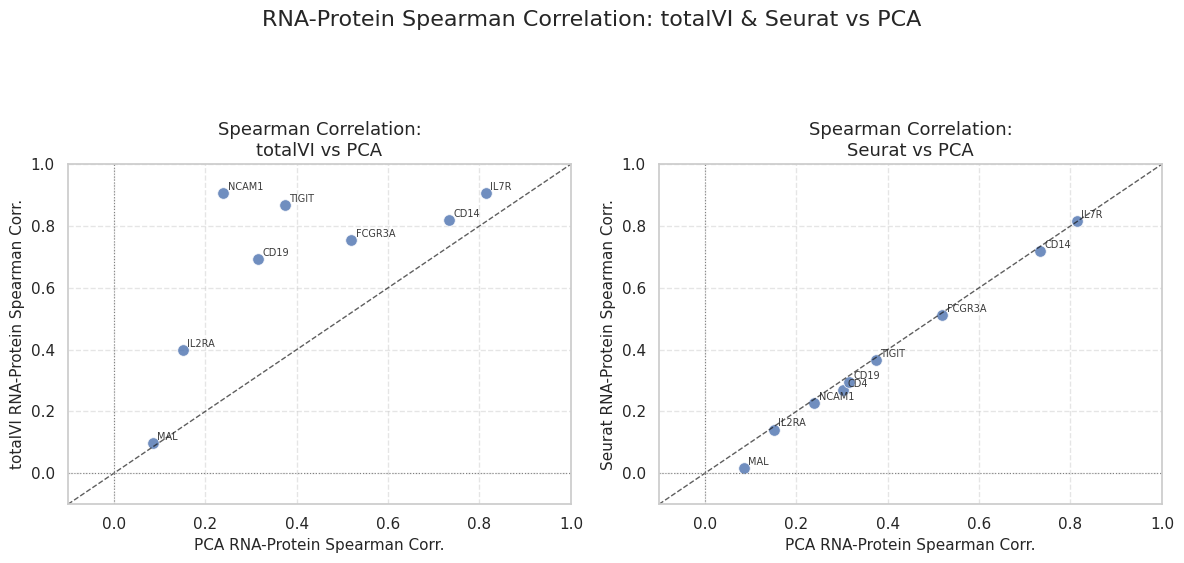

Scatter plots of Methods vs PCA correlations saved to: /content/drive/My Drive/CMML_ICA2/Benchmark_Analysis/figures/benchmark_plot_scatter_corr_vs_PCA.png

Block Benchmark-8c finished: RNA-Protein Correlation Visualization (Revised Scatter vs PCA).


In [20]:
# Block Benchmark-8c: Visualize RNA-Protein Correlations (Revised Scatter Plots - Method vs PCA)

# ... (previous code for loading benchmark_correlation_df and plotting distribution boxplots) ...
# Ensure benchmark_correlation_df contains "method", "RNA", "Protein", "Spearman_Correlation"

print("\n--- Generating Scatter Plots: Method vs PCA Spearman Correlations ---")

# Methods to compare against PCA
methods_to_compare_with_pca = ["totalVI", "Seurat"]
pca_method_name = "PCA" # PCA is now the reference for these scatter plots

# Prepare PCA's correlations for joining
if pca_method_name in benchmark_correlation_df["method"].unique():
    df_pca_corr_scatter = benchmark_correlation_df[
        benchmark_correlation_df["method"] == pca_method_name
    ].set_index(["RNA", "Protein"])[["Spearman_Correlation"]] # Select only Spearman and set index
else:
    print(f"ERROR: PCA method ('{pca_method_name}') not found in correlation data. Cannot create scatter plots vs PCA.")
    df_pca_corr_scatter = None


if df_pca_corr_scatter is not None and not df_pca_corr_scatter.empty:
    num_comparison_methods = len(methods_to_compare_with_pca)
    if num_comparison_methods == 0:
        print("No methods specified to compare against PCA. Skipping scatter plots.")
    else:
        fig_scatter_vs_pca, axes_scatter_vs_pca = plt.subplots(1, num_comparison_methods,
                                                               figsize=(6 * num_comparison_methods, 5.5),
                                                               squeeze=False) # Ensure axes is always 2D array for indexing

        plt.subplots_adjust(wspace=0.35)

        for idx, current_method_name in enumerate(methods_to_compare_with_pca):
            ax = axes_scatter_vs_pca[0, idx] # axes_scatter_vs_pca is now 2D

            if current_method_name not in benchmark_correlation_df["method"].unique():
                print(f"Method '{current_method_name}' not found in correlation data. Skipping its scatter plot.")
                ax.text(0.5, 0.5, f"{current_method_name}\nData N/A", ha='center', va='center', fontsize=10, color='red')
                ax.set_title(f"Spearman Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.set_xlabel(f"{pca_method_name} RNA-Protein Spearmann Corr.", fontsize=11)
                ax.set_ylabel(f"{current_method_name} RNA-Protein Spearman Corr.", fontsize=11)
                ax.grid(True, linestyle='--', alpha=0.5)
                ax.plot([0, 1], [0, 1], 'k--', lw=1)
                ax.set_xlim(-0.1, 1.05)
                ax.set_ylim(-0.1, 1.05)
                continue

            df_current_method_corr = benchmark_correlation_df[
                benchmark_correlation_df["method"] == current_method_name
            ].set_index(["RNA", "Protein"])[["Spearman_Correlation"]]

            # Merge with PCA's correlations
            merged_corr_for_plot_vs_pca = df_current_method_corr.join(
                df_pca_corr_scatter,
                lsuffix=f'_{current_method_name}',
                rsuffix=f'_{pca_method_name}',
                how='inner' # Only pairs present in both
            )

            # Rename columns for clarity
            col_current_method = f"Spearman_Correlation_{current_method_name}"
            col_pca_ref = f"Spearman_Correlation_{pca_method_name}"
            merged_corr_for_plot_vs_pca.rename(
                columns={col_current_method: "current_method_corr", col_pca_ref: "pca_ref_corr"},
                inplace=True
            )

            if not merged_corr_for_plot_vs_pca.empty:
                sns.scatterplot(x="pca_ref_corr", y="current_method_corr",
                                data=merged_corr_for_plot_vs_pca, alpha=0.8, s=70, ax=ax, legend=False)

                texts = []
                for rna_protein_pair_idx, row_data in merged_corr_for_plot_vs_pca.iterrows():
                    rna_name_label = rna_protein_pair_idx[0] # RNA name from tuple index
                    texts.append(ax.text(row_data["pca_ref_corr"] + 0.01, row_data["current_method_corr"] + 0.01,
                                         rna_name_label, fontsize=7, alpha=0.9))

                # Optional: adjust_text to prevent label overlap
                try:
                    from adjustText import adjust_text
                    adjust_text(texts, ax=ax,Lim_points=50,force_points=0.1, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5,alpha=0.5))
                except ImportError:
                    print(f"For {current_method_name} vs PCA: Package 'adjustText' not installed. Annotations might overlap.")

                all_values_plot = pd.concat([merged_corr_for_plot_vs_pca["pca_ref_corr"], merged_corr_for_plot_vs_pca["current_method_corr"]]).dropna()
                if not all_values_plot.empty:
                    min_val_p = min(-0.1, all_values_plot.min() - 0.05)
                    max_val_p = max(1.0, all_values_plot.max() + 0.05)
                    ax.plot([min_val_p, max_val_p], [min_val_p, max_val_p], 'k--', lw=1, alpha=0.7)
                    ax.set_xlim(min_val_p, max_val_p)
                    ax.set_ylim(min_val_p, max_val_p)
                else:
                    ax.plot([-0.1, 1], [-0.1, 1], 'k--', lw=1, alpha=0.7)
                    ax.set_xlim(-0.1, 1.05)
                    ax.set_ylim(-0.1, 1.05)

                ax.axhline(0, color='grey', linestyle=':', lw=0.8)
                ax.axvline(0, color='grey', linestyle=':', lw=0.8)
                ax.set_title(f"Spearman Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.set_xlabel(f"{pca_method_name} RNA-Protein Spearman Corr.", fontsize=11)
                ax.set_ylabel(f"{current_method_name} RNA-Protein Spearman Corr.", fontsize=11)
                ax.grid(True, linestyle='--', alpha=0.5)

            else:
                ax.text(0.5, 0.5, f"No common pairs\nfor {current_method_name}\nvs {pca_method_name}",
                        ha='center', va='center', fontsize=10, color='red')
                ax.set_title(f"Spearman Correlation:\n{current_method_name} vs {pca_method_name}", fontsize=13)
                ax.plot([0, 1], [0, 1], 'k--', lw=1)
                ax.set_xlim(-0.1, 1.05)
                ax.set_ylim(-0.1, 1.05)
                ax.grid(True, linestyle='--', alpha=0.5)

        fig_scatter_vs_pca.suptitle("RNA-Protein Spearman Correlation: totalVI & Seurat vs PCA", fontsize=16, y=1.05)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        scatter_corr_vs_pca_path = os.path.join(benchmark_figure_dir, "benchmark_plot_scatter_corr_vs_PCA.png")
        plt.savefig(scatter_corr_vs_pca_path, dpi=300)
        plt.show()
        plt.close(fig_scatter_vs_pca)
        print(f"Scatter plots of Methods vs PCA correlations saved to: {scatter_corr_vs_pca_path}")

elif df_pca_corr_scatter is None:
    pass # Error already printed
else: # df_pca_corr_scatter is empty
    print("PCA correlation data is empty. Skipping scatter plots vs PCA.")


print("\nBlock Benchmark-8c finished: RNA-Protein Correlation Visualization (Revised Scatter vs PCA).")